MACHINE LEARNING AND TIME SERIES
Previsão do Fechamento do Ibovespa


# Introdução

Este trabalho propõe uma análise preditiva do fechamento do Ibovespa, principal índice da Bolsa de Valores brasileira, utilizando dados históricos coletados entre 1º de janeiro de 2018 e 8 de fevereiro de 2024. Combinando técnicas de análise exploratória de dados e modelos de aprendizado de máquina, buscamos antecipar o comportamento futuro do Ibovespa, gerando insights úteis para investidores e stakeholders do mercado financeiro.

A metodologia inclui uma exploração detalhada dos dados históricos, técnicas de pré-processamento, seleção e treinamento de modelos de machine learning, além da avaliação rigorosa do desempenho desses modelos. Para isso, utilizaremos uma variedade de bibliotecas e ferramentas do ecossistema Python, como Plotly, Pandas, Numpy, Prophet, Statsmodels, Matplotlib, Scikit-learn, Seaborn e Keras.

Ao final deste estudo, esperamos apresentar insights relevantes sobre a capacidade preditiva do fechamento do Ibovespa, contribuindo para uma compreensão mais profunda dos padrões e tendências do mercado financeiro brasileiro e auxiliando na tomada de decisões estratégicas pelos investidores e agentes econômicos.

---

# Passos para a solução

### 1) Exploração e pré-processamento dos dados

In [1]:
#  Importando as bibliotecas necessárias e fazendo as configurações básicas

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller # verificar os dados estacionarios
from statsmodels.tsa.stattools import acf, pacf #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #decomposição sazonal usando médias móveis
from statsmodels.tsa.arima.model import ARIMA #algoritmo arima

from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import load_model
#from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Prophet
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [59]:
#  Passando o arquivo-base para uma variável do tipo pandas DataFrame.

ibovespa = pd.read_csv('Dados Históricos - Ibovespa.csv', sep = ',')

type(ibovespa)

pandas.core.frame.DataFrame

In [60]:
#  Visualizando a morfologia da tabela.

ibovespa

Data   Último  Abertura   Máxima   Mínima     Vol.    Var%
0     09.02.2024  128.026   128.216  128.896  127.579   12,12M  -0,15%
1     08.02.2024  128.217   129.950  130.126  127.912   13,63M  -1,33%
2     07.02.2024  129.950   130.412  130.552  129.426   15,43M  -0,36%
3     06.02.2024  130.416   127.593  130.417  127.593   13,78M   2,21%
4     05.02.2024  127.593   127.182  127.834  126.443    9,64M   0,32%
...          ...      ...       ...      ...      ...      ...     ...
5722  04.01.2001   16.675    16.597   16.933   16.587  331,23M   0,46%
5723  03.01.2001   16.599    15.425   16.599   15.251  381,20M   7,61%
5724  02.01.2001   15.425    15.242   15.621   15.174  230,63M   1,09%
5725  28.12.2000   15.259    15.188   15.269   15.132  324,26M   0,48%
5726  27.12.2000   15.186    14.805   15.223   14.805  239,98M   2,65%

[5727 rows x 7 columns]

In [61]:
#  Checando contagens de nulos e tipos de dados da tabela.

ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5727 entries, 0 to 5726
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5727 non-null   object 
 1   Último    5727 non-null   float64
 2   Abertura  5727 non-null   float64
 3   Máxima    5727 non-null   float64
 4   Mínima    5727 non-null   float64
 5   Vol.      5726 non-null   object 
 6   Var%      5727 non-null   object 
dtypes: float64(4), object(3)
memory usage: 313.3+ KB


In [62]:
ibovespa.describe()

Último     Abertura       Máxima       Mínima
count  5727.000000  5727.000000  5727.000000  5727.000000
mean     60.163023    60.144691    60.750107    59.546679
std      32.056126    32.049114    32.293852    31.804837
min       8.371000     8.397000     8.513000     8.225000
25%      37.897500    37.870500    38.452000    37.324500
50%      56.928000    56.930000    57.520000    56.313000
75%      77.957000    77.908500    78.875000    76.886000
max     134.194000   134.194000   134.389000   133.832000

In [63]:
ibovespa.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [64]:
ibovespa[ibovespa['Vol.'].isnull()]

Data  Último  Abertura  Máxima  Mínima Vol.    Var%
1986  10.02.2016  40.377    40.592  40.592   39.96  NaN  -0,53%

In [65]:
ibovespa.iloc[max(0, (ibovespa[ibovespa['Vol.'].isnull()].index[0])-5):min(ibovespa.shape[0], (ibovespa[ibovespa['Vol.'].isnull()].index[0])+6)]

Data  Último  Abertura  Máxima  Mínima   Vol.    Var%
1981  17.02.2016  41.631    40.958  42.436  40.958  5,47M   1,67%
1982  16.02.2016  40.948    40.093  41.206  40.074  4,04M   2,13%
1983  15.02.2016  40.093    39.808  40.671  39.808  1,75M   0,72%
1984  12.02.2016  39.808    39.324  39.901  39.324  3,43M   1,25%
1985  11.02.2016  39.318    40.370  40.370  38.928  3,79M  -2,62%
1986  10.02.2016  40.377    40.592  40.592  39.960    NaN  -0,53%
1987  05.02.2016  40.592    40.812  41.249  40.566  3,67M  -0,56%
1988  04.02.2016  40.822    39.589  41.444  39.589  5,56M   3,11%
1989  03.02.2016  39.589    38.597  39.726  38.597  4,37M   2,57%
1990  02.02.2016  38.596    40.564  40.564  38.596  4,56M  -4,87%
1991  01.02.2016  40.570    40.397  40.570  39.738  3,77M   0,41%

O que podemos determinar com as informações que temos até aqui?

* Nossa base contém os dados referentes ao índice Ibovespa em um período contínuo de 5.727 dias úteis, compreendendo as datas entre 27/12/2000 a 09/02/2024.

* Cada linha representa um dia nesse período, e traz os seguintes dados:
  - 'Último' = valor do índice no fechamento do mercado.
  - 'Abertura' = valor do índice na abertura do mercado.
  - 'Máxima' = valor mais alto (topo) alcançado pelo índice no dia.
  - 'Mínima' = valor mais baixo (fundo) alcançado pelo índice no dia.
  - 'Var%' = variação percentual entre os valores de abertura e de fechamento do dia.
  - 'Vol.' = volume de negócios.

* As colunas 'Data', 'Vol.' e 'Var%' tem dados do tipo object (string), apesar de representarem datas e valores numéricos.

* Existe uma linha com valor nulo na coluna 'Vol.'.

In [66]:
#  O tipo de dados da coluna 'Data' está como string. Vamos alterá-lo para datetime para facilitar a manipulação temporal dos dados.

ibovespa['Data'] = pd.to_datetime(ibovespa['Data'], format='%d.%m.%Y')

ibovespa['Data'].info()
ibovespa.head(3)

<class 'pandas.core.series.Series'>
RangeIndex: 5727 entries, 0 to 5726
Series name: Data
Non-Null Count  Dtype         
--------------  -----         
5727 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 44.9 KB


Data   Último  Abertura   Máxima   Mínima    Vol.    Var%
0 2024-02-09  128.026   128.216  128.896  127.579  12,12M  -0,15%
1 2024-02-08  128.217   129.950  130.126  127.912  13,63M  -1,33%
2 2024-02-07  129.950   130.412  130.552  129.426  15,43M  -0,36%

In [72]:
#  Vamos transformar o tipo de dados da coluna 'Var%' para float.

#ibovespa['Var%'] = ibovespa['Var%'].str.replace('.', '', regex=True).str.replace(',', '.', regex=True).str.replace('%', '', regex=True).astype('float64')  / 100
ibovespa['Var%'] = ibovespa['Var%'].str.replace(',', '.', regex=True).str.replace('%', '', regex=True).astype('float64')  / 100


ibovespa['Var%'].info()
ibovespa.head(3)

<class 'pandas.core.series.Series'>
RangeIndex: 5727 entries, 0 to 5726
Series name: Var%
Non-Null Count  Dtype  
--------------  -----  
5727 non-null   float64
dtypes: float64(1)
memory usage: 44.9 KB


Data   Último  Abertura   Máxima   Mínima    Vol.    Var%
0 2024-02-09  128.026   128.216  128.896  127.579  12,12M -0.0015
1 2024-02-08  128.217   129.950  130.126  127.912  13,63M -0.0133
2 2024-02-07  129.950   130.412  130.552  129.426  15,43M -0.0036

In [74]:
#  Vamos colocar o valor "0,00M" na linha com valor nulo da coluna 'Vol.'. Depois vamos transformar os valores dessa coluna em números (int).

ibovespa['Vol.'].fillna('0,00M', inplace=True)

def converter_volume(valor):
  if valor.endswith('K'):
    return int(float(valor[:-1].replace(',', '.')) * 1000)
  elif valor.endswith('M'):
    return int(float(valor[:-1].replace(',', '.')) * 1000000)
  else:
    return None

ibovespa['Volume'] = ibovespa['Vol.'].apply(converter_volume)
ibovespa = ibovespa.drop(columns=['Vol.'])

ibovespa['Volume'].info()
ibovespa.head(3)

<class 'pandas.core.series.Series'>
RangeIndex: 5727 entries, 0 to 5726
Series name: Volume
Non-Null Count  Dtype
--------------  -----
5727 non-null   int64
dtypes: int64(1)
memory usage: 44.9 KB


Data   Último  Abertura   Máxima   Mínima    Var%    Volume
0 2024-02-09  128.026   128.216  128.896  127.579 -0.0015  12120000
1 2024-02-08  128.217   129.950  130.126  127.912 -0.0133  13630000
2 2024-02-07  129.950   130.412  130.552  129.426 -0.0036  15430000

**Motivo para a Seleção do Período**

Para o estudo em questão selecionamos um período na base de 01/01/2018 até 09/02/2024. Abaixo estão algumas justificativas:

* Para o melhor funcionamento dos modelos e para que haja uma captura melhor dos padrões atuais;

* Com uma seleção de período muito longa, as relações entre as variáveis ​​podem mudar significativamente devido a mudanças em condições econômicas, tecnológicas, políticas e sociais. Com um período muito longo os modelos podem capturar padrões que não são mais relevantes ou podem falhar em capturar novos padrões emergentes;

* Padrões sazonais e tendências podem mudar ao longo do tempo. Modelos treinados em um período de tempo muito longo podem não ser sensíveis a essas mudanças e podem produzir previsões imprecisas;

* Um período de tempo muito longo pode tendenciar o modelo a overfitting mais facilmente.

In [75]:

# Seleção de período de estudos 01/01/2018 até a data final da base 09/02/2024


ibovespa = ibovespa.sort_values('Data')

ibovespa = ibovespa.set_index('Data', drop=False)

ibovespa = ibovespa.loc['2018-01-01':,:]

ibovespa.head()

Data  Último  Abertura  Máxima  Mínima    Var%   Volume
Data                                                                    
2018-01-02 2018-01-02  77.891    76.403  77.909  76.403  0.0195  2970000
2018-01-03 2018-01-03  77.995    77.889  78.414  77.602  0.0013  3240000
2018-01-04 2018-01-04  78.647    77.998  79.135  77.998  0.0084  3590000
2018-01-05 2018-01-05  79.071    78.644  79.071  78.218  0.0054  2830000
2018-01-08 2018-01-08  79.379    79.070  79.395  78.631  0.0039  2630000

Agora que ajustamos o dataframe, podemos explorar as estatísticas e visualizações dos nossos dados.

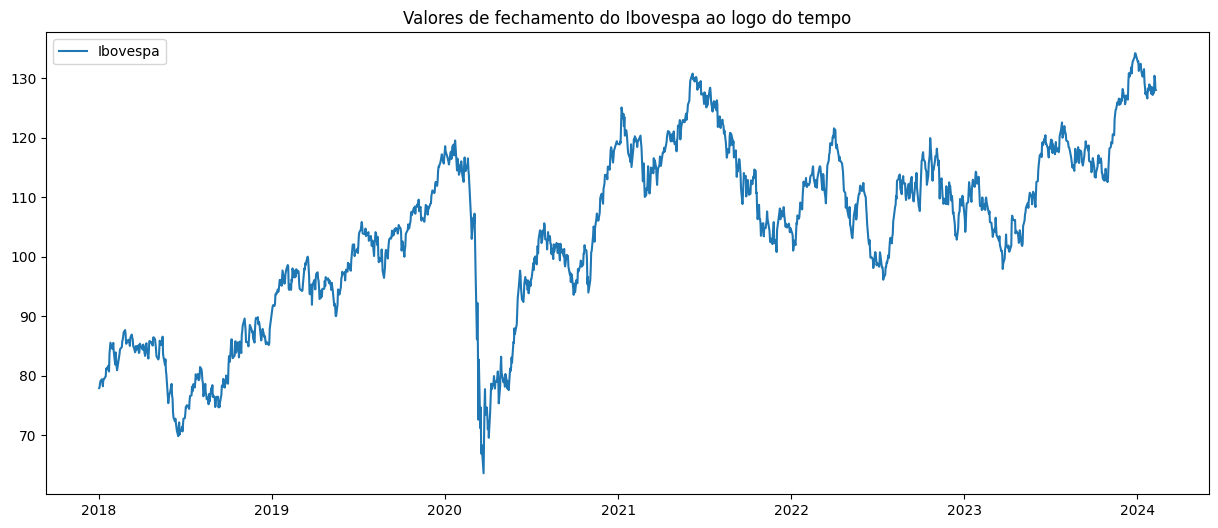

In [76]:
#  Visualizando os valores de fechamento

plt.figure(figsize = (15,6))
plt.plot(ibovespa['Data'], ibovespa['Último'], label='Ibovespa')
plt.title("Valores de fechamento do Ibovespa ao logo do tempo")
plt.legend(loc='best')
plt.show()

Analisando os dados do gráfico **Valores de fechamento do Ibovespa** ao longo do tempo, notamos que ao longo do período analisado, o ano de 2020 apresentou a maior queda no indicador do Ibovespa, sendo explicado principalmente pela **Pandemia da Covid** chegou de forma acelerada e impactou os mercados financeiros de todo mundo, uma vez que, a cada dia que se passou, novas medidas restritivas eram adotadas pelos governos, impactando diretamente no crescimento econômico interno. Muitas economias entraram em recessão econômicas; com o lockdown muito presente no dia a dia, o dólar começou a apresentar queda; notamos a desaceleração no crescimento econômico, e tratando-se de Ibovespa, o impacto foi surreal, onde muitas ações “derreteram” a ponto de que vários papéis nunca se recuperaram, e em maior dimensão destaca-se as empresas do setor de turismo, onde seus papéis listados passaram a vales centavos.

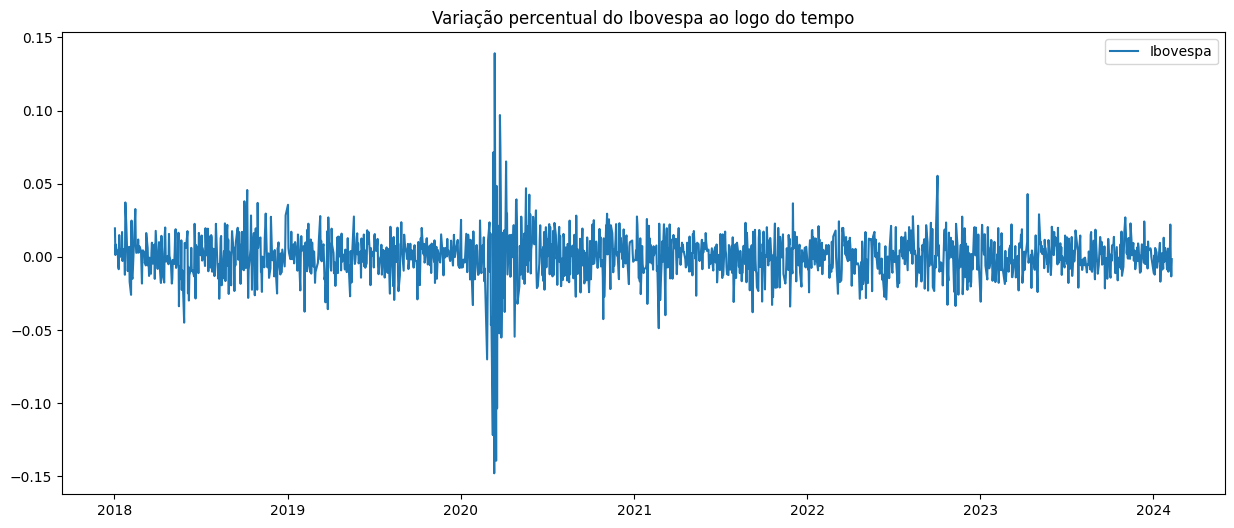

In [77]:
#  Visualizando a variação percentual

plt.figure(figsize = (15,6))
plt.plot(ibovespa['Data'], ibovespa['Var%'], label='Ibovespa')
plt.title("Variação percentual do Ibovespa ao logo do tempo")
plt.legend(loc='best')
plt.show()

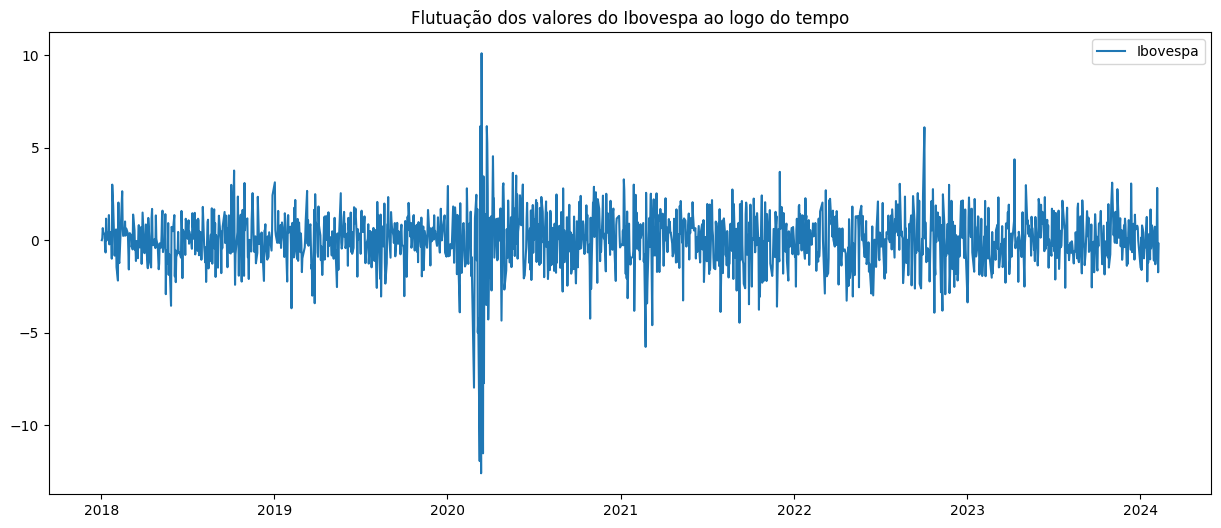

In [78]:
#  Vamos criar uma coluna que mostre a flutuação do valor de fechamento, isto é, a variação desse valor de um dia para o outro.

ibovespa['Flutuação'] = ibovespa[['Último']].diff()

ibovespa['Flutuação'].fillna(0.00, inplace=True)

plt.figure(figsize = (15,6))
plt.plot(ibovespa['Data'], ibovespa['Flutuação'], label='Ibovespa')
plt.title("Flutuação dos valores do Ibovespa ao logo do tempo")
plt.legend(loc='best')
plt.show()

In [79]:
ibovespa.describe()

Data       Último     Abertura       Máxima  \
count                           1516  1516.000000  1516.000000  1516.000000   
mean   2021-01-23 00:35:08.707123968   104.151496   104.119356   105.101840   
min              2018-01-02 00:00:00    63.570000    63.604000    67.604000   
25%              2019-07-17 18:00:00    95.593750    95.574750    96.569000   
50%              2021-01-26 12:00:00   105.878000   105.842000   106.822000   
75%              2022-08-03 06:00:00   115.193000   115.183250   116.185000   
max              2024-02-09 00:00:00   134.194000   134.194000   134.389000   
std                              NaN    14.608644    14.614428    14.540822   

            Mínima         Var%        Volume    Flutuação  
count  1516.000000  1516.000000  1.516000e+03  1516.000000  
mean    103.154625     0.000472  8.990379e+06     0.033071  
min      61.691000    -0.147800  3.909300e+05   -12.588000  
25%      94.635750    -0.007600  5.117500e+06    -0.782500  
50%     104.932500     0.000650  9.155000e+06     0.065000  
75%     114.300500     0.009100  1.174000e+07     0.951750  
max     133.832000     0.139100  2.603000e+07    10.095000  
std      14.665039     0.016118  4.083476e+06     1.540827

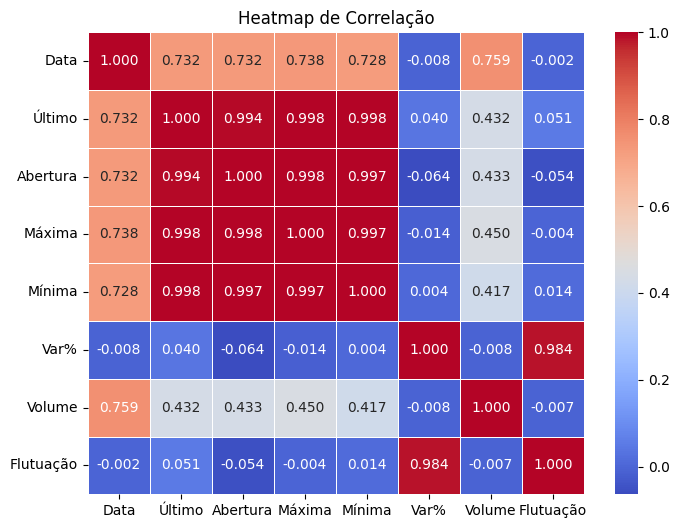

In [80]:
matriz_correlacao = ibovespa.corr(numeric_only=False)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)
plt.title("Heatmap de Correlação")
plt.show()

O que podemos determinar com as informações que temos até aqui?

* Ao longo dessas duas décadas, o retorno do Ibovespa foi bastante positivo. O valor mais recente representa uma valorização de 844% sobre o mais antigo da série.
* Porém, quando analisamos as variações, percebemos que essa valorização não ocorreu de maneira uniforme. Vemos duas quedas bastante acentuadas, um em 2008 e outra em 2020, e um grande período com idas e vindas que, na prática, resultaram em estagnação, entre 2011 e 2017.
* A correlação do valor de fechamento com os valores de abertura, máximos e mínimos é bastante alta. Já com o volume de negócios é negativa e apenas moderada. Por fim, com as medidas de variação diária, não há correlação.

In [81]:
#  Copiando o dataframe para outra variável, mantendo apenas a data como índice e a coluna 'Último' com o valor de fechamento

ibovespa = ibovespa.drop(columns = 'Data')

df_limpo = ibovespa
df_limpo = df_limpo.sort_index()
df_limpo = df_limpo.drop(columns=["Abertura","Máxima","Mínima","Var%","Volume","Flutuação"])

In [82]:
df_limpo

Último
Data               
2018-01-02   77.891
2018-01-03   77.995
2018-01-04   78.647
2018-01-05   79.071
2018-01-08   79.379
...             ...
2024-02-05  127.593
2024-02-06  130.416
2024-02-07  129.950
2024-02-08  128.217
2024-02-09  128.026

[1516 rows x 1 columns]

### 2) Teste de modelo 1: **Médias móveis**



In [83]:
df = pd.DataFrame(df_limpo[['Último']])

In [84]:
df['MA_window_10'] = df['Último'].rolling(10).mean().shift() #média móvel em 10 dias
df['MA_window_20'] = df['Último'].rolling(20).mean().shift() #média móvel em 20 dias

In [85]:
df.head(30)

Último  MA_window_10  MA_window_20
Data                                          
2018-01-02  77.891           NaN           NaN
2018-01-03  77.995           NaN           NaN
2018-01-04  78.647           NaN           NaN
2018-01-05  79.071           NaN           NaN
2018-01-08  79.379           NaN           NaN
2018-01-09  78.864           NaN           NaN
2018-01-10  78.201           NaN           NaN
2018-01-11  79.365           NaN           NaN
2018-01-12  79.349           NaN           NaN
2018-01-15  79.752           NaN           NaN
2018-01-16  79.832       78.8514           NaN
2018-01-17  81.189       79.0455           NaN
2018-01-18  80.963       79.3649           NaN
2018-01-19  81.220       79.5965           NaN
2018-01-22  81.675       79.8114           NaN
2018-01-23  80.678       80.0410           NaN
2018-01-24  83.680       80.2224           NaN
2018-01-26  85.531       80.7703           NaN
2018-01-29  84.698       81.3869           NaN
2018-01-30  84.482       81.9218           NaN
2018-01-31  84.913       82.3948      80.62310
2018-02-01  85.495       82.9029      80.97420
2018-02-02  84.041       83.3335      81.34920
2018-02-05  81.861       83.6413      81.61890
2018-02-06  83.894       83.7054      81.75840
2018-02-07  82.767       83.9273      81.98415
2018-02-08  81.533       84.1362      82.17930
2018-02-09  80.899       83.9215      82.34590
2018-02-14  83.543       83.4583      82.42260
2018-02-15  84.291       83.3428      82.63230

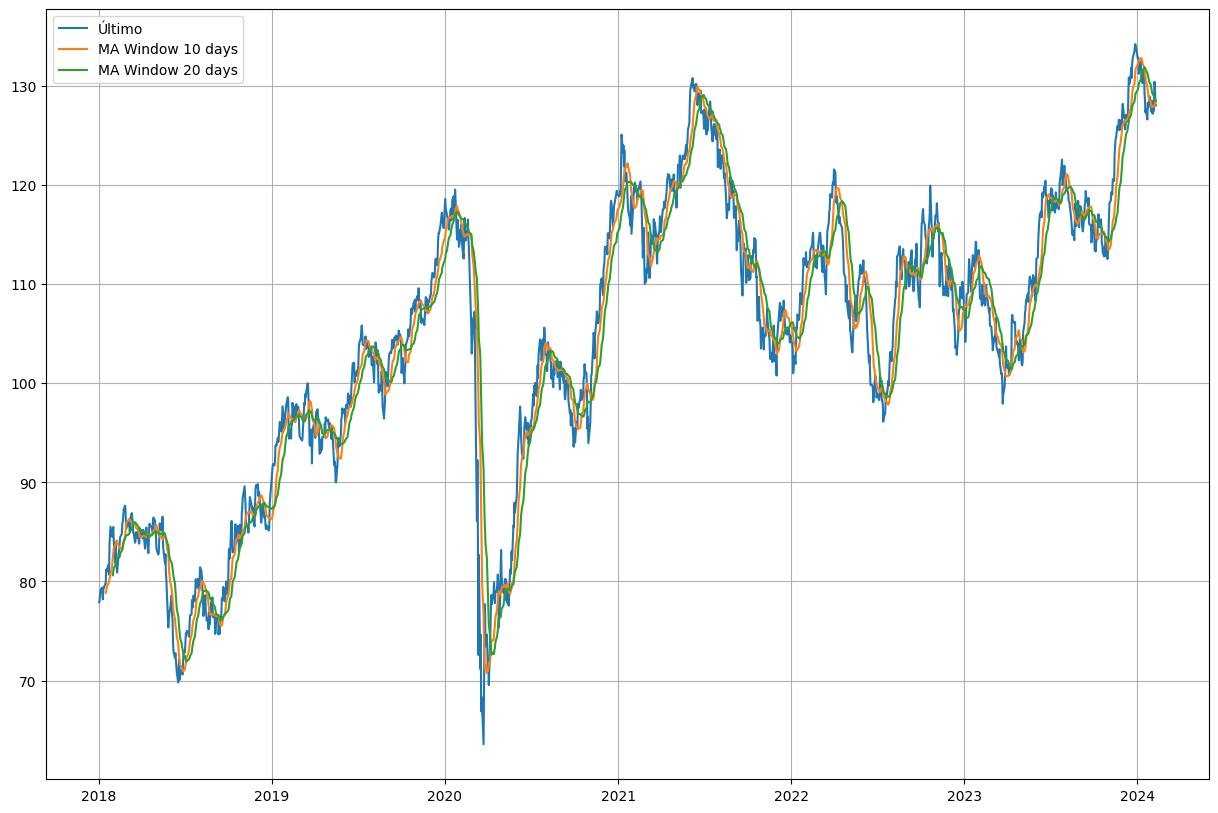

In [86]:
# Visualizando o resultado

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Último'], label='Último')
plt.plot(df['MA_window_10'], label='MA Window 10 days')
plt.plot(df['MA_window_20'], label='MA Window 20 days')
plt.legend(loc=2)
plt.show()

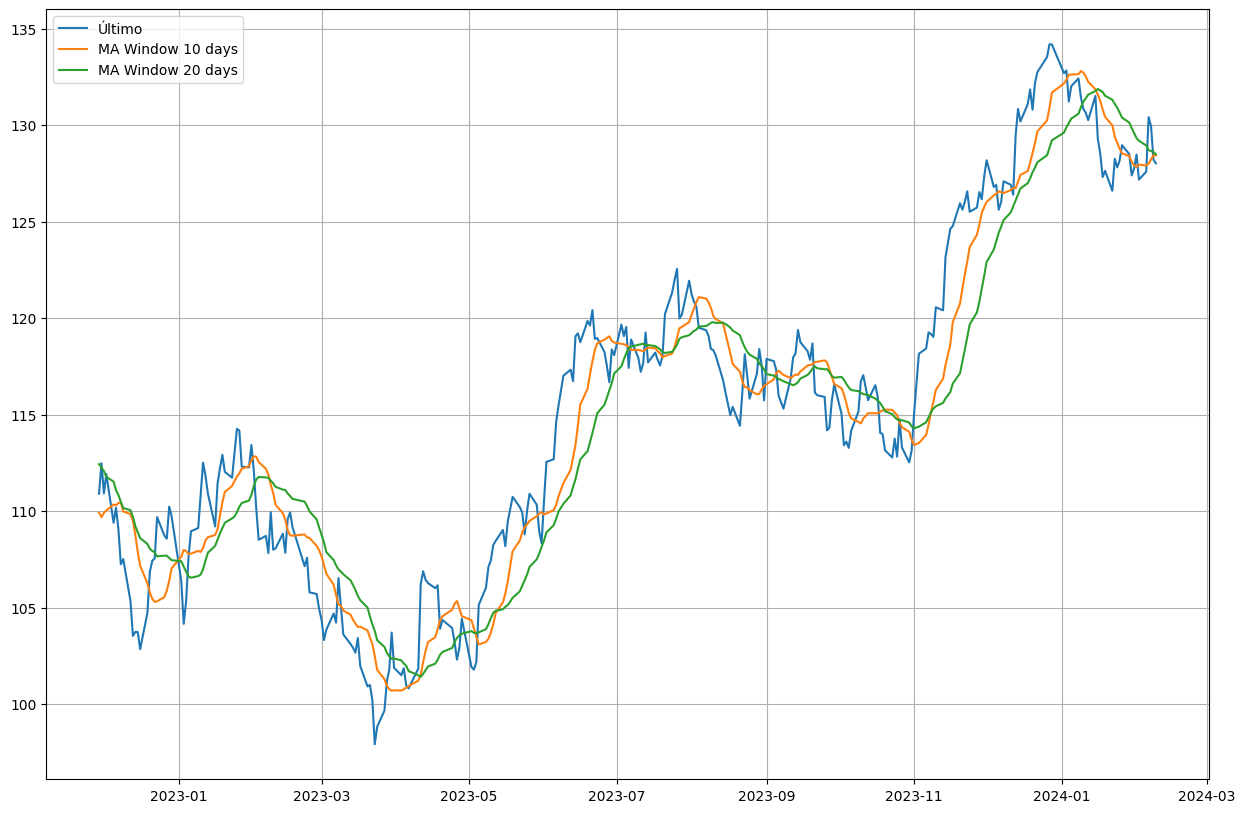

In [88]:
# dar um zoom nos dados pra ver se realmente está assertivo

limit = 300

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Último'][- limit:], label='Último')
plt.plot(df['MA_window_10'][- limit:], label='MA Window 10 days')
plt.plot(df['MA_window_20'][- limit:], label='MA Window 20 days')
plt.legend(loc=2)
plt.show()

> Prevendo os 'N' dias com base na média móvel aritmética

In [89]:
df['MA_window_10_forward_10'] = np.NaN #preenchendo com NaN os valores da coluna de MA_window_10_foward_10

In [90]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)] #realizando a janela de tempo

In [91]:
window_size = 10
forward_days = 10

for index in range(window_size, len(df), forward_days):
    for i in range(0, forward_days):
        if index + i >= len(df):
            break
        window_close = make_window(window_size - i,  index + i - window_size)
        window_MA = make_window(i, index)
        mean = pd.concat([df['Último'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean

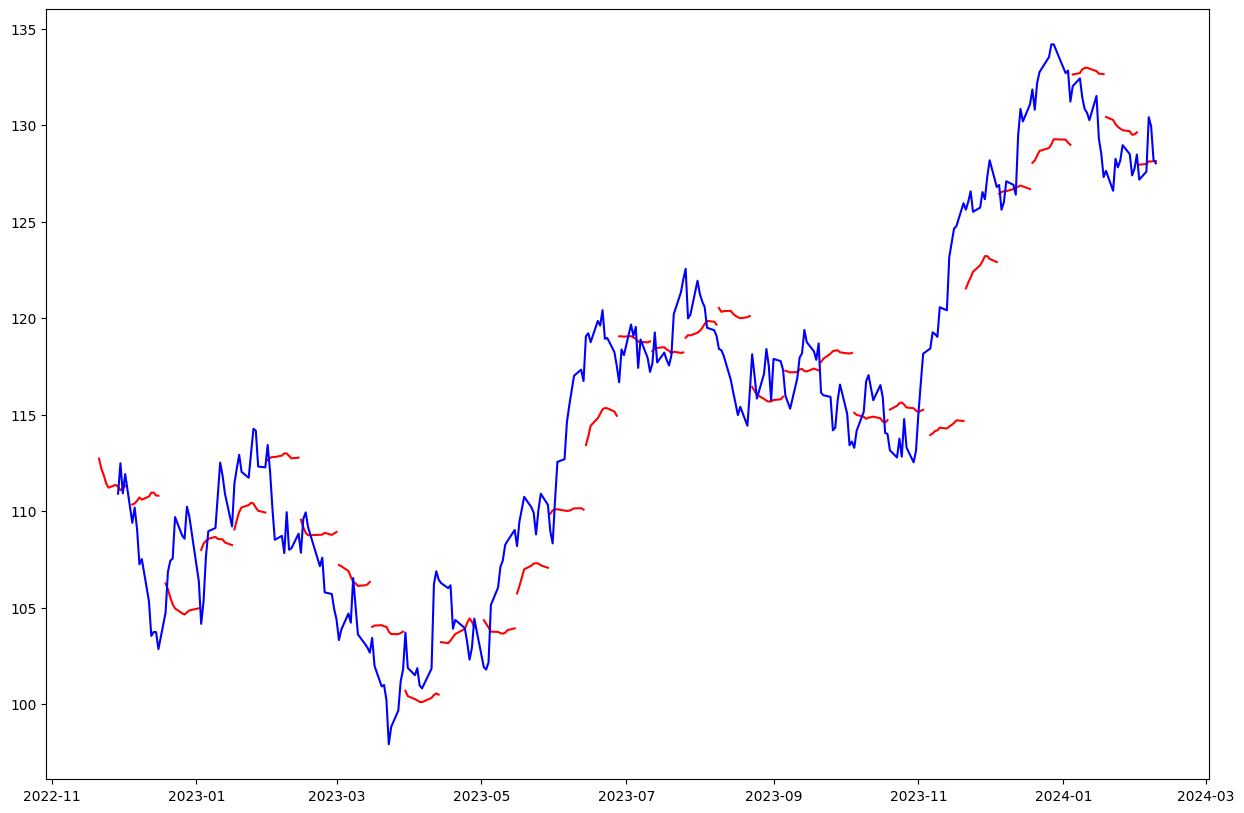

In [92]:
# Plotando os dados:

plt.figure(figsize=(15,10))
size = len(df)-limit - (len(df)-limit)%forward_days
for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')
plt.plot(df['Último'][-limit:], color='b', label='Último')
#plt.legend(loc='best')
plt.show()

Note que cada linha vermelha no gráfico representa uma previsão de 10 dias, baseada nos 10 dias anteriores.
Por isso elas são descontínuas.

Esse tipo de abordagem é muito simplista. Isso porque o verdadeiro objetivo é prever N dias a frente para ver qual será
o comportamento da ação. E ambos os algoritmos falharam nessa função.

> Analisando a Correlação dos dados:

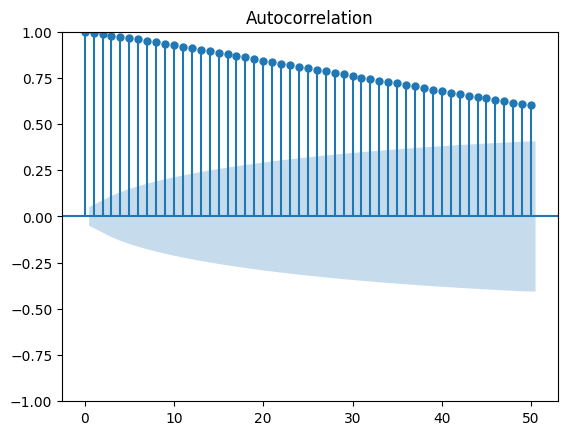

In [93]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df_limpo, lags=50)
plt.show()

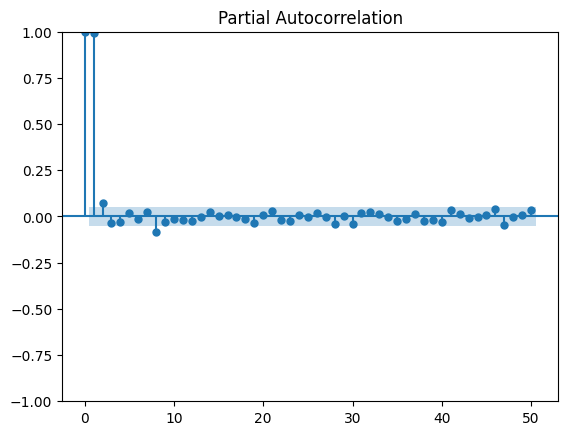

In [94]:
sm.graphics.tsa.plot_pacf(df_limpo, lags=50)
plt.show()

> Analisando a média móvel com o desvio padrão

In [95]:
rolmean = df_limpo.rolling(window=12).mean() # média móvel em 12 meses (dando a média móvel no nível anual)
rolstd = df_limpo.rolling(window=12).std() #desvio padrão em 12 meses
print(rolmean, rolstd)

                Último
Data                  
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-08         NaN
...                ...
2024-02-05  127.863833
2024-02-06  128.095500
2024-02-07  128.374500
2024-02-08  128.370667
2024-02-09  128.388167

[1516 rows x 1 columns]               Último
Data                
2018-01-02       NaN
2018-01-03       NaN
2018-01-04       NaN
2018-01-05       NaN
2018-01-08       NaN
...              ...
2024-02-05  0.651525
2024-02-06  0.976401
2024-02-07  0.989099
2024-02-08  0.989659
2024-02-09  0.980776

[1516 rows x 1 columns]


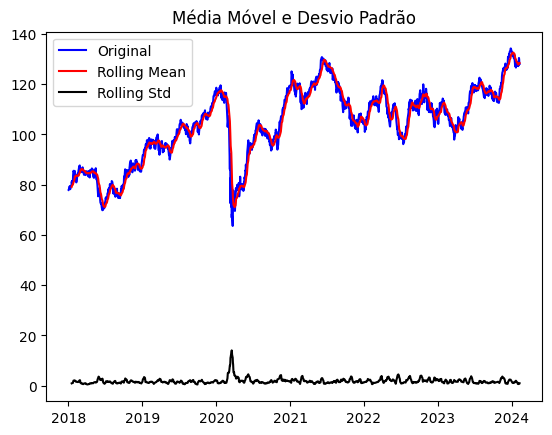

In [96]:
# plotando a média móvel

orig = plt.plot(df_limpo, color = 'blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média Móvel e Desvio Padrão')
plt.show(block=False)

> Verificando estacionariedade da série temporal

##### Teste de Dickey-Fuller

In [97]:
from statsmodels.tsa.stattools import adfuller

# teste de estacionariedade (AADF test)
adf_result = adfuller(df_limpo['Último'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do teste de estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico: ', adf_result[0])
print('Valor-p: ', adf_result[1])
print('Valores Críticos: ')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.287172782133289
p-value: 0.1761383841574054
Resultados do teste de estacionariedade:
--------------------------------------
Teste Estatístico:  -2.287172782133289
Valor-p:  0.1761383841574054
Valores Críticos: 
   1%: -3.434696697851678
   5%: -2.8634597924260303
   10%: -2.567792072971565


> Transformando em Série Estacionária

#### 1º TESTE: SUBTRAIR OS DADOS TRANSFORMADOS PELO LOG PELA MÉDIA MÓVEL

Objetivo: Estabilizar a Variância em uma série temporal, especialmente quando a amplitude dos dados varia ao longo do tempo.

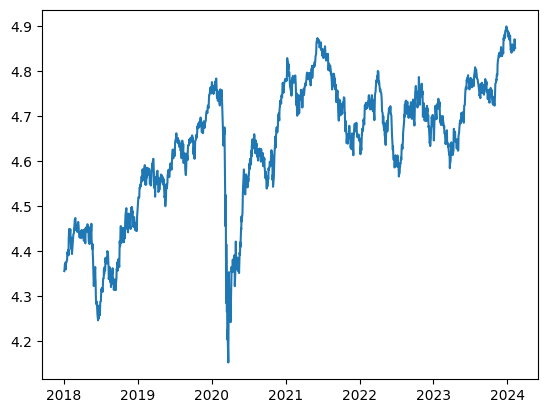

In [99]:
indexedDataset_logScale = np.log(df_limpo) # transformação Logarítmica
plt.plot(indexedDataset_logScale)
plt.show()

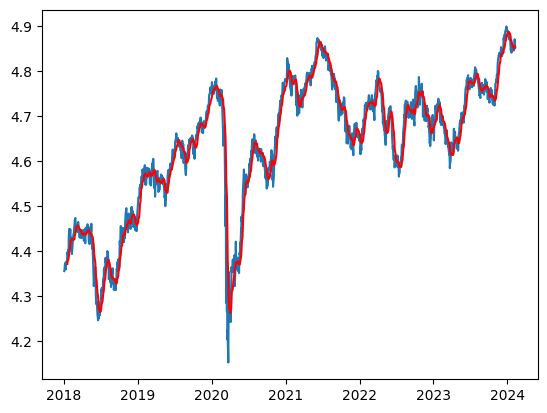

In [100]:
# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')
plt.show()

In [101]:
# Vamos subtrair os dados transformados pelo log menos a média móvel para remover o componente de tendência de ambos.
# (Aqui buscamos isolar os padrões sazonais ou os componentes residuais.)

datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

# Remove NaN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

Último
Data                
2018-01-17  0.025775
2018-01-18  0.019765
2018-01-19  0.019557
2018-01-22  0.021996
2018-01-23  0.008037
2018-01-24  0.040174
2018-01-26  0.055290
2018-01-29  0.038852
2018-01-30  0.031092
2018-01-31  0.030533

In [102]:
# função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    # determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    # plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # performance do Dickey-Fuller:
    print('Results os Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Último'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value
    print(dfoutput)

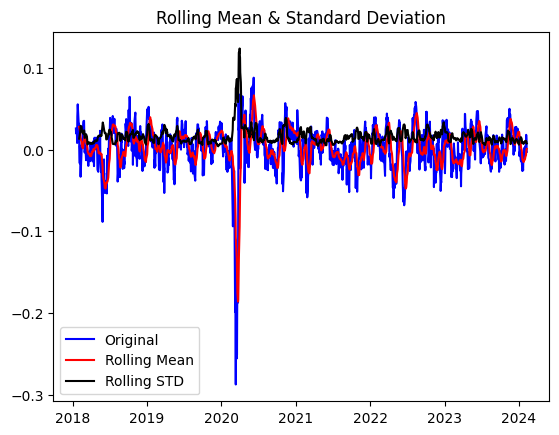

Results os Dickey-Fuller Test:
Test Statistic                -9.645714e+00
P-Value                        1.479786e-16
#Lags Used                     7.000000e+00
Number of observations Used    1.497000e+03
Critical Values (1%)          -3.434726e+00
Critical Values (5%)          -2.863473e+00
Critical Values (10%)         -2.567799e+00
dtype: float64


In [103]:
test_stationarity(datasetLogScaleMinusMovingAverage)

O desvio padrão ficou mais próximo da média móvel desta vez.

E o p-value ficou 0.000000000000001479786.



#### 2º TESTE: DECAIMENTO EXPONENCIAL

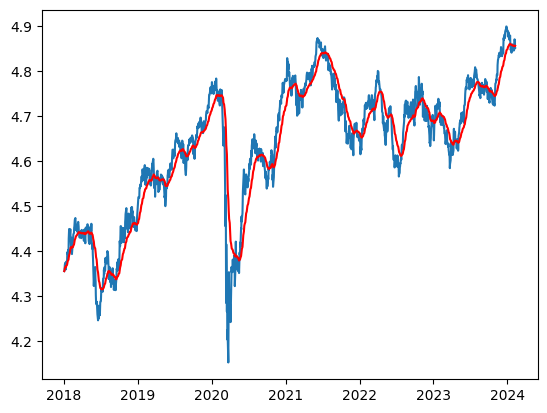

In [104]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

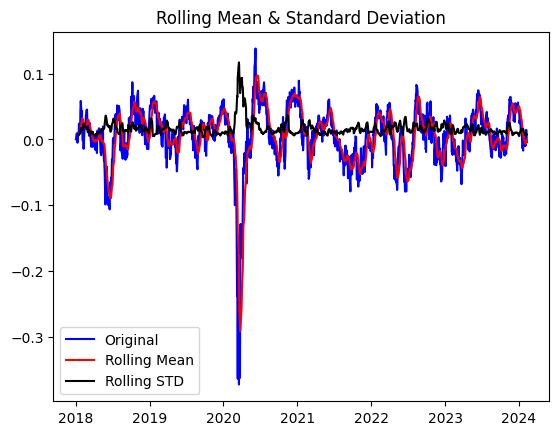

Results os Dickey-Fuller Test:
Test Statistic                -6.076415e+00
P-Value                        1.118806e-07
#Lags Used                     8.000000e+00
Number of observations Used    1.507000e+03
Critical Values (1%)          -3.434697e+00
Critical Values (5%)          -2.863460e+00
Critical Values (10%)         -2.567792e+00
dtype: float64


In [105]:
#subtraindo o dataset em escala logarítmica pelo decaimento exponencial
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

#### 3º TESTE: DIFERENCIAÇÃO

Objetivo: Remover a tendência e tornar a série mais estacionária.

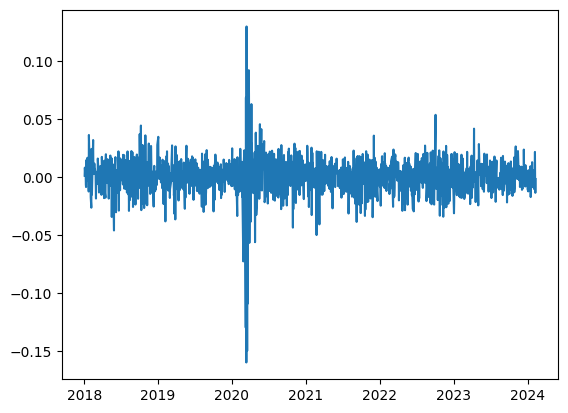

In [106]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() # diferença entre valor anterior e o atual
plt.plot(datasetLogDiffShifting)

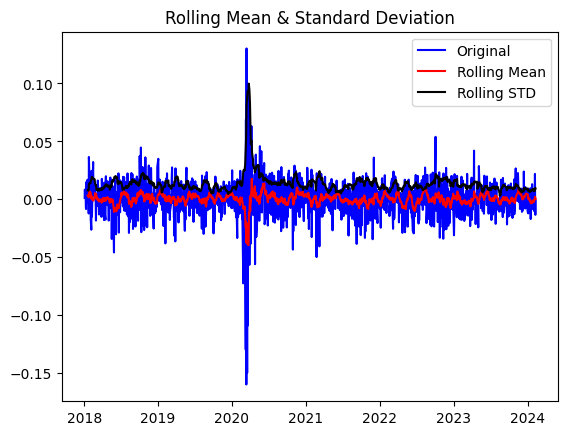

Results os Dickey-Fuller Test:
Test Statistic                -1.204049e+01
P-Value                        2.739472e-22
#Lags Used                     7.000000e+00
Number of observations Used    1.507000e+03
Critical Values (1%)          -3.434697e+00
Critical Values (5%)          -2.863460e+00
Critical Values (10%)         -2.567792e+00
dtype: float64


In [107]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

##### >>> Teste de correlação Parcial

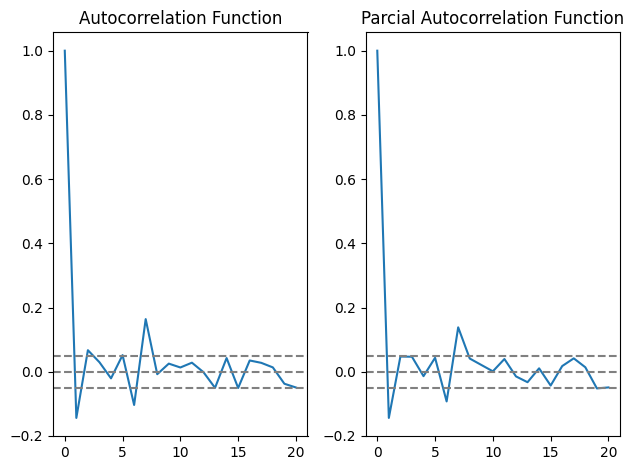

In [108]:
# ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

# plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title("Autocorrelation Function")

# plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title("Parcial Autocorrelation Function")

plt.tight_layout()

Ploting AR model


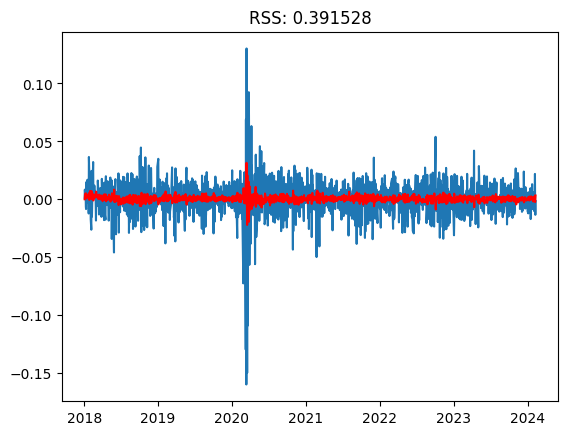

In [109]:
# AR model
model = ARIMA(datasetLogDiffShifting, order=(2,1,2)) #(p que achou no gráfico acima,d é o número de diferenciações que criou na base, q que achou no gráfico acima)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Último'])**2))
print('Ploting AR model')

O RSS (Residual Sum of Squares), ou Soma dos Quadrados dos Resíduos, é uma métrica de erro usada para avaliar o ajuste de um modelo de regressão. 
Ele representa a soma dos quadrados das diferenças entre os valores observados e os valores previstos pelo modelo.

Com um resultado de 0,39 o RSS pode ser considerado baixo ou alto dependendo do desempenho de outros modelos. Se outro modelo apresentar um RSS menor
(por exemplo, 0,25), ele seria mais adequado, mas tudo depende de um comparativo e contexto, ele não possui um valor ideal universal a ser considerado
como bom.

##### >> Validando o modelo com o MAPE (Mean Absolute Percentage Error)

In [111]:
from sklearn.metrics import mean_absolute_error

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale[ 'Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum (predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['Último'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Último'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 484.07%


O MAPE representa o Erro Percentual Absoluto Médio. Logo, quanto menor o MAPE, maior a taxa de acerto.

Modelo ARIMA resultou em um MAPE altíssimo. Isso quer dizer que as previsões do modelo estão muito distantes dos valores reais.

### 3) Teste de modelo 2: **ARIMA**

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [113]:
#Transformando a coluna de data em datetime

dados_update = ibovespa

In [114]:
dados_update

Último  Abertura   Máxima   Mínima    Var%    Volume  Flutuação
Data                                                                        
2018-01-02   77.891    76.403   77.909   76.403  0.0195   2970000      0.000
2018-01-03   77.995    77.889   78.414   77.602  0.0013   3240000      0.104
2018-01-04   78.647    77.998   79.135   77.998  0.0084   3590000      0.652
2018-01-05   79.071    78.644   79.071   78.218  0.0054   2830000      0.424
2018-01-08   79.379    79.070   79.395   78.631  0.0039   2630000      0.308
...             ...       ...      ...      ...     ...       ...        ...
2024-02-05  127.593   127.182  127.834  126.443  0.0032   9640000      0.411
2024-02-06  130.416   127.593  130.417  127.593  0.0221  13780000      2.823
2024-02-07  129.950   130.412  130.552  129.426 -0.0036  15430000     -0.466
2024-02-08  128.217   129.950  130.126  127.912 -0.0133  13630000     -1.733
2024-02-09  128.026   128.216  128.896  127.579 -0.0015  12120000     -0.191

[1516 rows x 7 columns]

In [116]:
#Removendo colunas que não são target e não possuem correlação

dados_update = ibovespa.drop(columns=["Abertura","Máxima","Mínima","Var%","Volume","Flutuação"])

dados_update

Último
Data               
2018-01-02   77.891
2018-01-03   77.995
2018-01-04   78.647
2018-01-05   79.071
2018-01-08   79.379
...             ...
2024-02-05  127.593
2024-02-06  130.416
2024-02-07  129.950
2024-02-08  128.217
2024-02-09  128.026

[1516 rows x 1 columns]

In [117]:
import statsmodels.api as sm


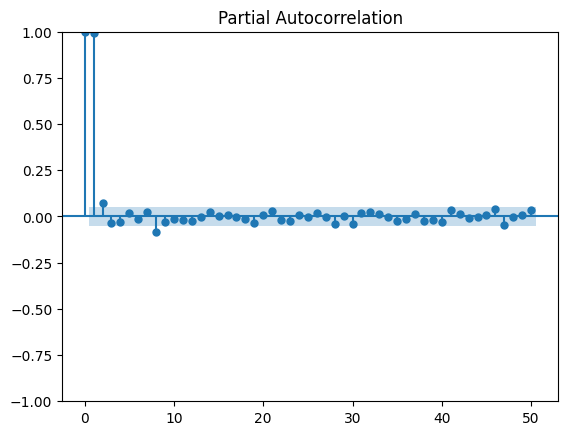

In [118]:
sm.graphics.tsa.plot_pacf(dados_update, lags=50)
plt.show()

In [119]:
#Realizar a decomposição da serie

resultados = seasonal_decompose(dados_update, model='multiplicative', period=5)

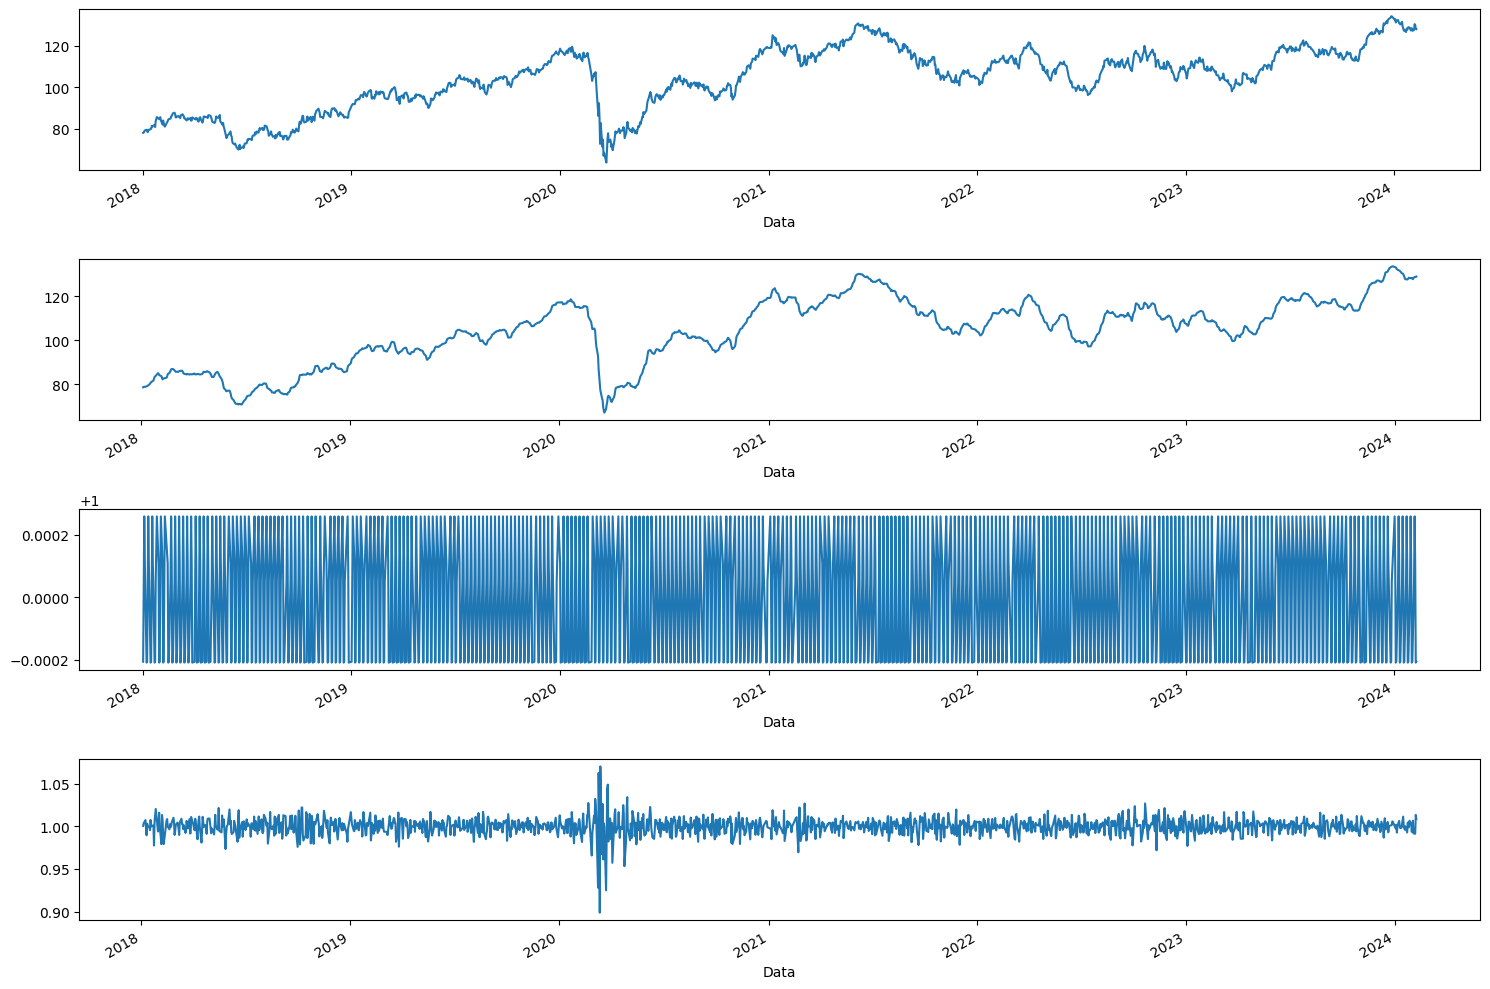

In [120]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)         # GRAFICO
resultados.trend.plot(ax=ax2)            # TENDENCIA
resultados.seasonal.plot(ax=ax3)         # SAZONALIDADE
resultados.resid.plot(ax=ax4)            # RESIDUO

plt.tight_layout()

Temos muito resíduo, portanto não se trata de série estacionária.

In [121]:
from statsmodels.tsa.stattools import adfuller

In [122]:
sns.set_style('darkgrid')

In [123]:
X = dados_update.Último.values

Teste de Dickey-Fuller ✍

Para aumentar ainda mais nossa hipótese de que a série temporal não é estacionária, vamos realizar o teste ADCF:

O teste de Dickey-Fuller Aumentado (ADF) permite saber se há presença significativa de tendência nas séries temporais das variáveis por meio de um teste de hipótese.

In [124]:
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.287172782133289
P-Value: 0.1761383841574054
Valores críticos:
	1%: -3.434696697851678
	5%: -2.8634597924260303
	10%: -2.567792072971565


Estacionária ou não estacionária: ADF - Augmented Dickey Fuller

* H0 - Hipótese nula (não é série estacionária)
* H1 - Hipótese alternativa (rejeição da hipótese nula)

* Se p-value <= 0.005, então podemos rejeitar H0 com um nível de confiança de 95%

*p-value = 0.1761, logo, não podemos rejeitar a hipótese nula.*

TRANSFORMANDO EM ESTACIONARIA

In [125]:
# Aplicando a diferenciação para tentar tornar estacionario

serie_diferenciada = dados_update.diff().dropna()

In [126]:
serie_diferenciada

Último
Data              
2018-01-03   0.104
2018-01-04   0.652
2018-01-05   0.424
2018-01-08   0.308
2018-01-09  -0.515
...            ...
2024-02-05   0.411
2024-02-06   2.823
2024-02-07  -0.466
2024-02-08  -1.733
2024-02-09  -0.191

[1515 rows x 1 columns]

In [127]:
resultados2 = seasonal_decompose(serie_diferenciada, period=5)

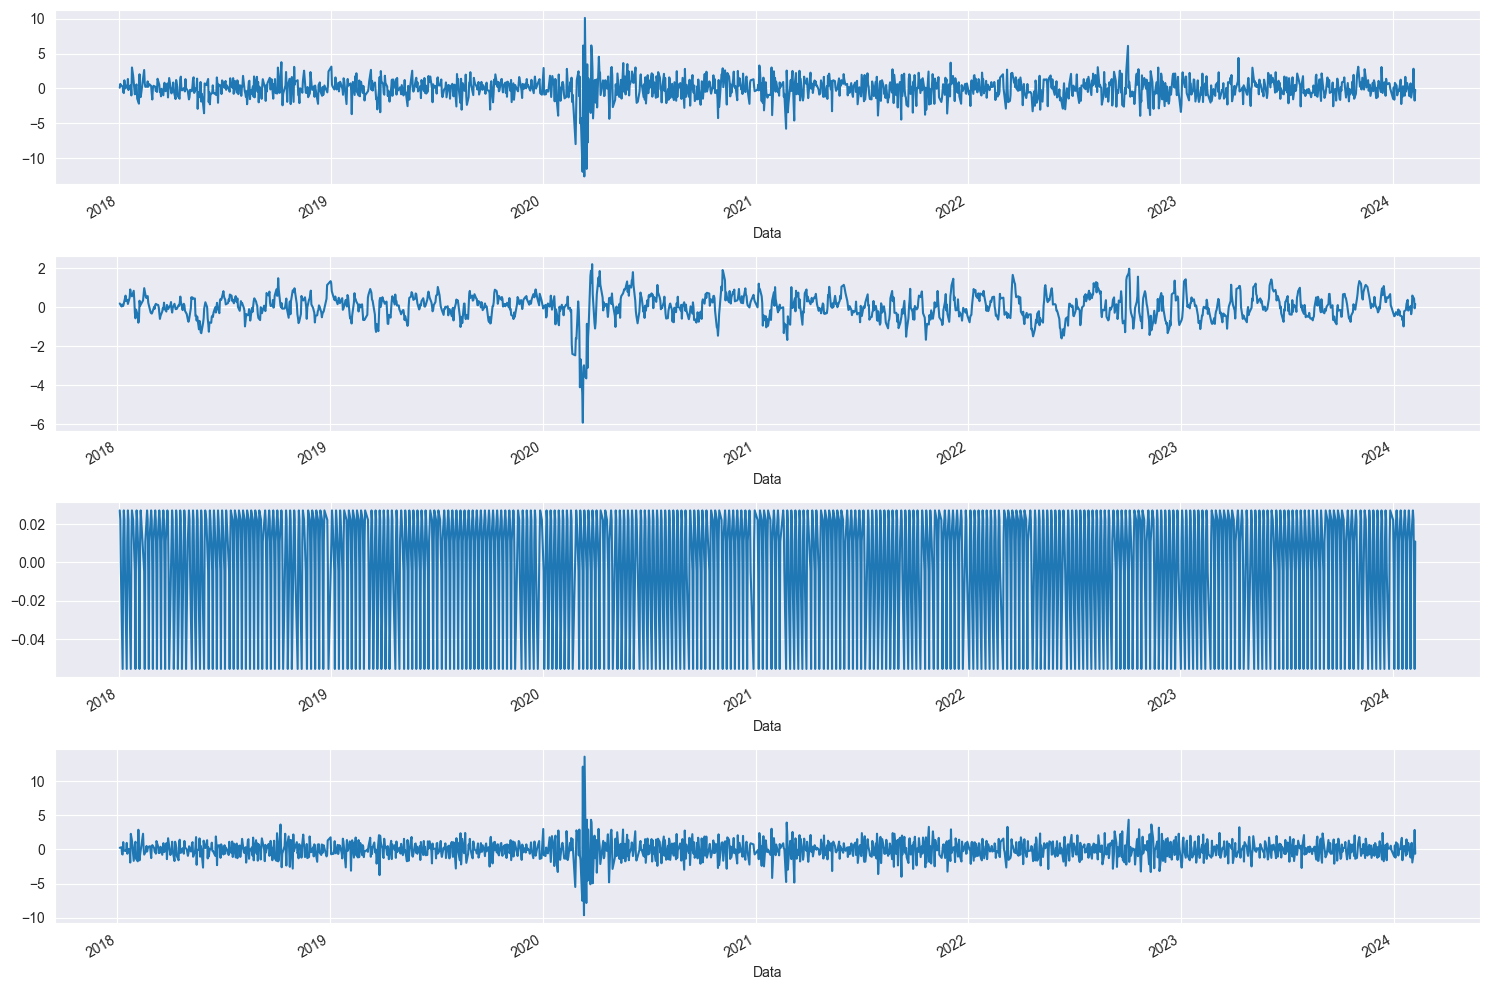

In [128]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados2.observed.plot(ax=ax1)         # GRAFICO
resultados2.trend.plot(ax=ax2)            # TENDENCIA
resultados2.seasonal.plot(ax=ax3)         # SAZONALIDADE
resultados2.resid.plot(ax=ax4)            # RESIDUO

plt.tight_layout()

In [129]:
X2 = serie_diferenciada.Último.values

In [130]:
result2 = adfuller(X2)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.287172782133289
P-Value: 0.1761383841574054
Valores críticos:
	1%: -3.434696697851678
	5%: -2.8634597924260303
	10%: -2.567792072971565


Mesmo após essa manipulação, a série se mantém não estacionária, o que dificulta rodar o modelo ARIMA.

### 4) Teste de modelo 3: **Prophet**

In [132]:
start_date = '01/01/2018'
end_date = '09/02/2024'


df = pd.read_csv('Dados Históricos - Ibovespa.csv')
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df = df[(df['Data'] >= start_date) & (df['Data'] <= end_date)]
df.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True)
df[['ds', 'y']] = df[['Data', 'Último']]
df = df.sort_values('Data')
df = df.reset_index(drop=True)

df

Data   Último         ds        y
0    2018-01-02   77.891 2018-01-02   77.891
1    2018-01-03   77.995 2018-01-03   77.995
2    2018-01-04   78.647 2018-01-04   78.647
3    2018-01-05   79.071 2018-01-05   79.071
4    2018-01-08   79.379 2018-01-08   79.379
...         ...      ...        ...      ...
1511 2024-02-05  127.593 2024-02-05  127.593
1512 2024-02-06  130.416 2024-02-06  130.416
1513 2024-02-07  129.950 2024-02-07  129.950
1514 2024-02-08  128.217 2024-02-08  128.217
1515 2024-02-09  128.026 2024-02-09  128.026

[1516 rows x 4 columns]

Separando os dados entre Treino e Teste

In [133]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'Training data size: {train_data.shape}')
print(f'Testing data size: {test_data.shape}')

Training data size: (1213, 4)
Testing data size: (303, 4)


In [134]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:26:02 - cmdstanpy - INFO - Chain [1] done processing


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-01-02  77.806084   77.566780   91.115103    77.806084    77.806084   
1 2018-01-03  77.806792   76.884200   90.942104    77.806792    77.806792   
2 2018-01-04  77.807500   76.782874   91.108472    77.807500    77.807500   
3 2018-01-05  77.808208   76.473245   91.053329    77.808208    77.808208   
4 2018-01-08  77.810333   77.134363   90.685437    77.810333    77.810333   

   additive_terms  additive_terms_lower  additive_terms_upper     daily  ...  \
0        5.982081              5.982081              5.982081  2.652768  ...   
1        6.246467              6.246467              6.246467  2.652768  ...   
2        6.164777              6.164777              6.164777  2.652768  ...   
3        6.092322              6.092322              6.092322  2.652768  ...   
4        6.540411              6.540411              6.540411  2.652768  ...   

     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0  0.112916      0.112916      0.112916  3.216396      3.216396      3.216396   
1  0.292525      0.292525      0.292525  3.301173      3.301173      3.301173   
2  0.125333      0.125333      0.125333  3.386676      3.386676      3.386676   
3 -0.032661     -0.032661     -0.032661  3.472215      3.472215      3.472215   
4  0.165079      0.165079      0.165079  3.722564      3.722564      3.722564   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  83.788164  
1                         0.0  84.053259  
2                         0.0  83.972277  
3                         0.0  83.900530  
4                         0.0  84.350744  

[5 rows x 22 columns]

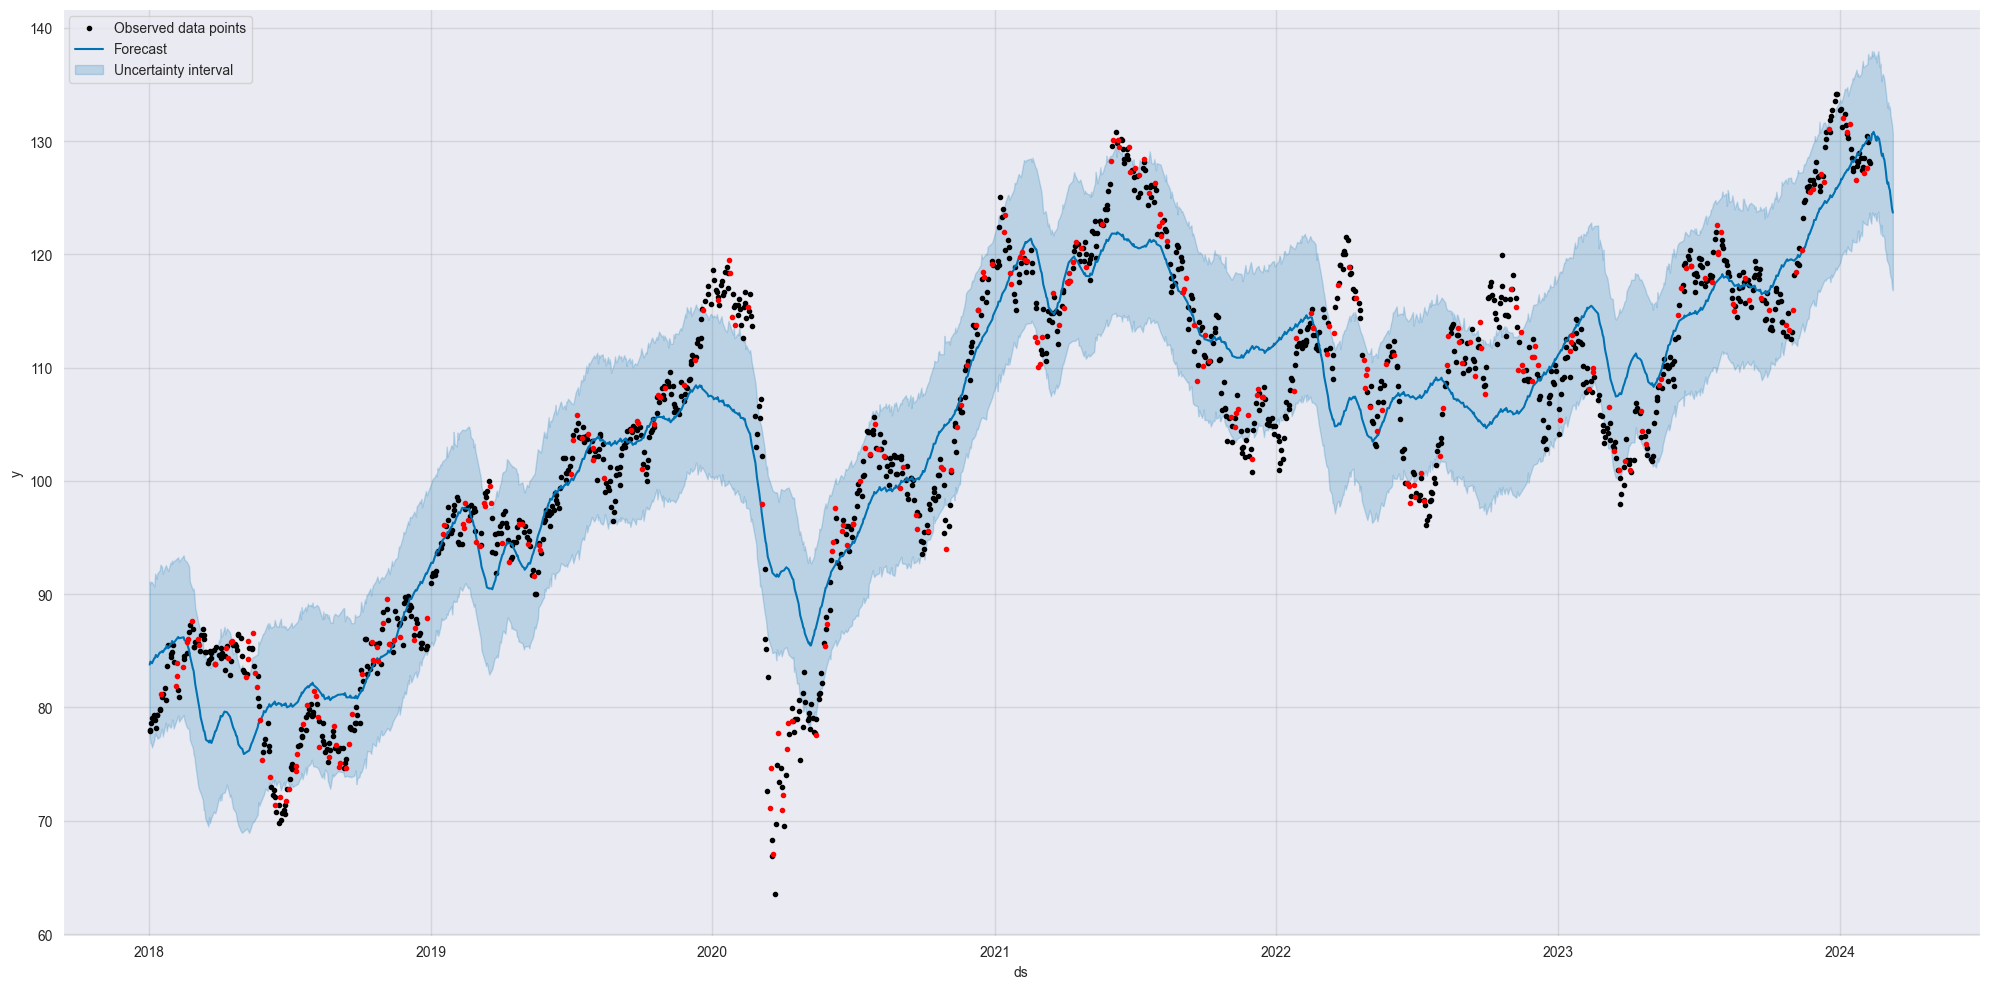

In [136]:
#COLOCAR TÍTULO DO GRÁFICO
#LEGENDA

modelo.plot(previsao, figsize=(20,10))
plt.plot(test_data['ds'], test_data['y'], '.r')

plt.legend()

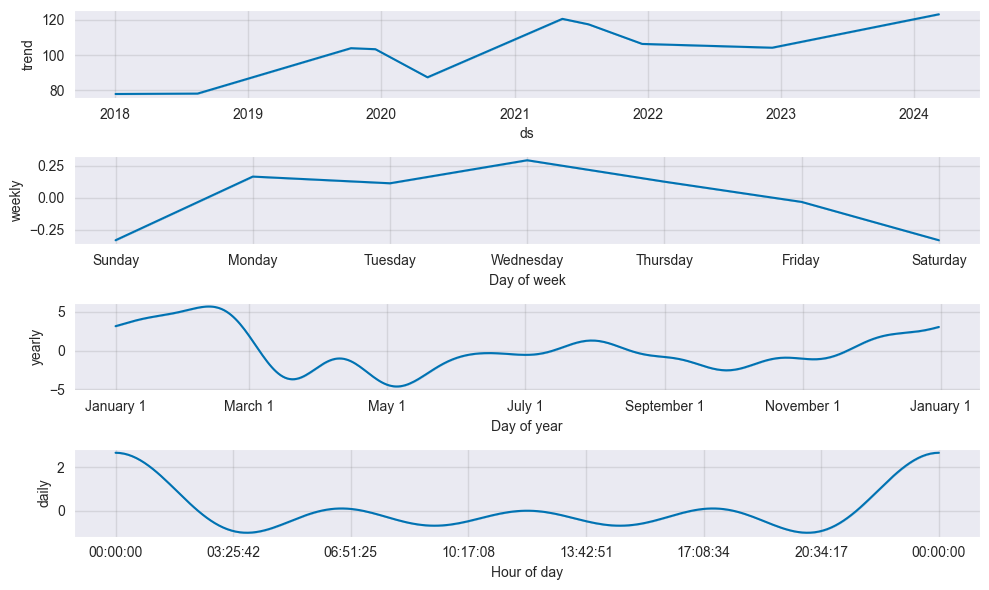

In [138]:
modelo.plot_components(previsao, figsize=(10,6));

Adicionando Changepoints no modelo

In [139]:
from prophet.plot import add_changepoints_to_plot


modelo_changepoints = Prophet(n_changepoints=5)
modelo_changepoints.fit(train_data)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=30, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.head()

13:27:34 - cmdstanpy - INFO - Chain [1] start processing
13:27:34 - cmdstanpy - INFO - Chain [1] done processing


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-01-02  77.813464   70.792080   91.059478    77.813464    77.813464   
1 2018-01-03  77.846716   71.029666   91.365744    77.846716    77.846716   
2 2018-01-04  77.879967   70.922811   91.523264    77.879967    77.879967   
3 2018-01-05  77.913218   70.934689   91.043170    77.913218    77.913218   
4 2018-01-08  78.012972   71.708283   92.699893    78.012972    78.012972   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        3.224567              3.224567              3.224567 -0.040038   
1        3.433397              3.433397              3.433397  0.069461   
2        3.476112              3.476112              3.476112  0.009140   
3        3.355372              3.355372              3.355372 -0.217421   
4        4.143149              4.143149              4.143149  0.246142   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -0.040038     -0.040038  3.264606      3.264606      3.264606   
1      0.069461      0.069461  3.363936      3.363936      3.363936   
2      0.009140      0.009140  3.466973      3.466973      3.466973   
3     -0.217421     -0.217421  3.572793      3.572793      3.572793   
4      0.246142      0.246142  3.897007      3.897007      3.897007   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  81.038032  
1                         0.0  81.280113  
2                         0.0  81.356079  
3                         0.0  81.268591  
4                         0.0  82.156121

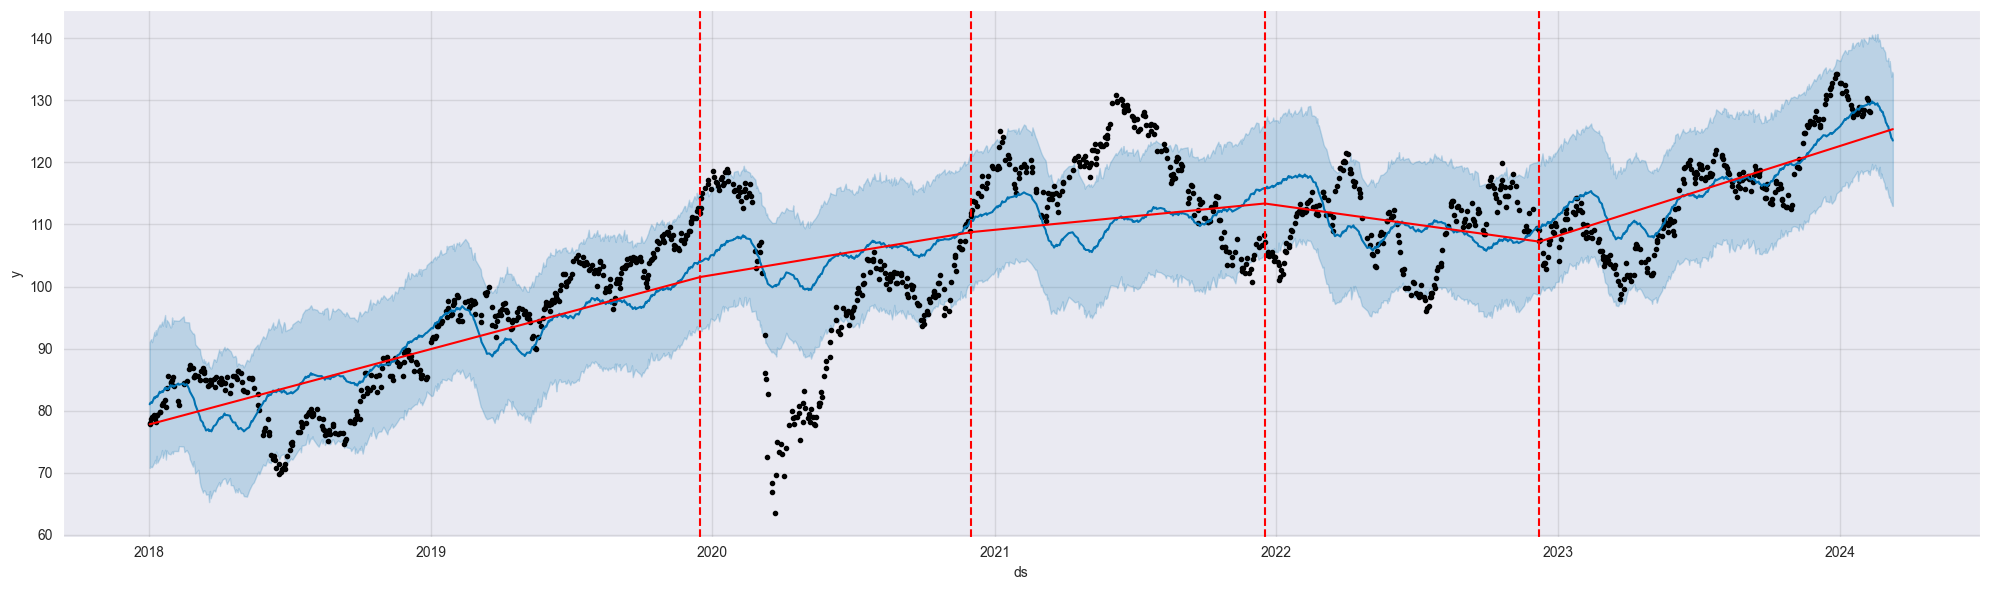

In [140]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6));
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

No gráfico acima, podemos visualizar ao longo do tempo 4 pontos de mudanças (changepoints).

1º Em meados do final de 2019 e início de 2020, verificamos uma oscilação na curva de previsão do modelo, pois houve uma leve acentuada no indicador, provocando um deslocamento da curva para cima. Entre fatores exógenos que ajudam a explicar essa mudança, podemos destacar: reforma da previdência com o propósito de melhorar a situação fiscal do Brasil; Retomada da operação lava jato; Reforma tributária afim de simplicar e estimular o crescimento econômico; Primeiros casos identificados da COVID-19 na China; Impeachment de Donald Trump; entre outros.

2º Em meados do final de 2020 e início de 2021, verificamos que apesar de estarmos vivendo um momento de pandemia global, onde Ibovespa apresentou queda, mas conseguiu conter e manter uma estabilidade e retomada de uma melhora contínua mês a mês. Entre explicações exógenas, destaca-se a crise econômica provida da pandemia; Queimadas na amazônia que impactou o mundo todo; Crises humanitárias e Avanço tecnológico com a criação de vacinas.

3º Em meados do final de 2021 e início de 2022, mais um changepoints onde vemos uma constante estabilidade seguida de leve crescimento, no entanto uma curva de previsão muito incerta, indicando quedas e seguidas de crescimento no indicador do Ibovespa, e pode ser explicado por eleições presidenciáveis no Brasil; inúmeros desafios econômicos, sociais, climáticos e de meio ambiente; covid 19 e suas variantes; tensões políticas internacionais; etc.

4ª Em meados do final de 2022 e inicio de 2023, tivemos uma curva de estabilidade mas com uma previsão nada otimista, onde a curva de tendência mostrava oscilação, seguida de recuo. Podemos destacar, entre acontecimentos a posse do novo presidente; a invação no prédio dos três poderes; gurerra Israel x Hamas; terremotos; ondas de calor e já no final do ano, tivemos a posse do novo presidente da Argentina (país membro do Mercosul e influente parceiro do Brasil nas operações de importação e exportação).


In [141]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao [previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])
print(f"MAPE: {mape:.2f}%")

MAPE: 4.27%


Cross validation

In [142]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon='365 days')

  0%|          | 0/7 [00:00<?, ?it/s]

13:27:52 - cmdstanpy - INFO - Chain [1] start processing
13:27:52 - cmdstanpy - INFO - Chain [1] done processing
13:27:52 - cmdstanpy - INFO - Chain [1] start processing
13:27:52 - cmdstanpy - INFO - Chain [1] done processing
13:27:53 - cmdstanpy - INFO - Chain [1] start processing
13:27:53 - cmdstanpy - INFO - Chain [1] done processing
13:27:53 - cmdstanpy - INFO - Chain [1] start processing
13:27:53 - cmdstanpy - INFO - Chain [1] done processing
13:27:54 - cmdstanpy - INFO - Chain [1] start processing
13:27:54 - cmdstanpy - INFO - Chain [1] done processing
13:27:55 - cmdstanpy - INFO - Chain [1] start processing
13:27:55 - cmdstanpy - INFO - Chain [1] done processing
13:27:55 - cmdstanpy - INFO - Chain [1] start processing
13:27:56 - cmdstanpy - INFO - Chain [1] done processing


In [143]:
df_cv.tail()

ds        yhat  yhat_lower  yhat_upper        y     cutoff
1381 2024-02-01  116.289840   91.927077  142.110559  128.481 2023-02-09
1382 2024-02-06  116.943813   92.155129  143.642250  130.416 2023-02-09
1383 2024-02-07  117.241920   93.601703  143.320769  129.950 2023-02-09
1384 2024-02-08  117.206958   92.646012  142.450235  128.217 2023-02-09
1385 2024-02-09  117.326402   91.577048  143.203056  128.026 2023-02-09

In [144]:
df_cv['cutoff'].unique()

<DatetimeArray>
['2020-02-25 00:00:00', '2020-08-23 00:00:00', '2021-02-19 00:00:00',
 '2021-08-18 00:00:00', '2022-02-14 00:00:00', '2022-08-13 00:00:00',
 '2023-02-09 00:00:00']
Length: 7, dtype: datetime64[ns]

In [145]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p

horizon          mse       rmse        mae      mape     mdape     smape  \
0    37 days   242.301690  15.566043  11.793937  0.123645  0.087102  0.113378   
1    38 days   259.054175  16.095160  12.111188  0.128008  0.089373  0.116985   
2    39 days   262.217384  16.193128  12.140387  0.128111  0.088345  0.117324   
3    40 days   262.299206  16.195654  12.117312  0.127910  0.088345  0.117042   
4    41 days   272.198019  16.498425  12.335481  0.131166  0.089373  0.119500   
..       ...          ...        ...        ...       ...       ...       ...   
324 361 days  1263.168865  35.541087  31.786586  0.284753  0.275123  0.274833   
325 362 days  1256.067349  35.441040  31.659157  0.283447  0.275123  0.272992   
326 363 days  1250.534741  35.362901  31.584879  0.282625  0.275398  0.272304   
327 364 days  1232.267657  35.103670  31.375818  0.280227  0.274695  0.270455   
328 365 days  1207.151821  34.744090  31.073061  0.276798  0.274695  0.268217   

     coverage  
0    0.289855  
1    0.300000  
2    0.311594  
3    0.317391  
4    0.311594  
..        ...  
324  0.326087  
325  0.336957  
326  0.337681  
327  0.344928  
328  0.360507  

[329 rows x 8 columns]

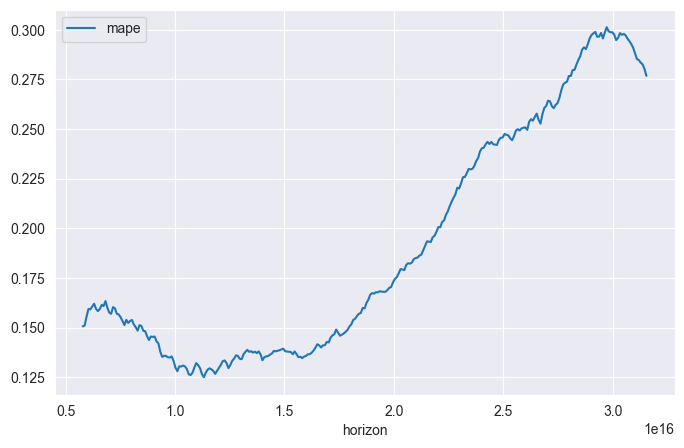

In [146]:
# plotando o MAPE do prophet

plt.figure(figsize=(8,5))
plt.plot(df_p.iloc[30:,:]['horizon'], df_p.iloc[30:,:]['mape'], label='mape')
#plt.plot(df_p['horizon'], df_p['mae'], label='mae')
plt.xlabel('horizon')

plt.legend(loc='best')
plt.show()

### 5) Teste de modelo 4: **LSTM**

In [147]:
df = ibovespa.copy()
df = df.reset_index()
df.head(5)

Data  Último  Abertura  Máxima  Mínima    Var%   Volume  Flutuação
0 2018-01-02  77.891    76.403  77.909  76.403  0.0195  2970000      0.000
1 2018-01-03  77.995    77.889  78.414  77.602  0.0013  3240000      0.104
2 2018-01-04  78.647    77.998  79.135  77.998  0.0084  3590000      0.652
3 2018-01-05  79.071    78.644  79.071  78.218  0.0054  2830000      0.424
4 2018-01-08  79.379    79.070  79.395  78.631  0.0039  2630000      0.308

In [148]:
df.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Volume', 'Var%', 'Flutuação'], inplace=True)
df.head()

Data  Último
0 2018-01-02  77.891
1 2018-01-03  77.995
2 2018-01-04  78.647
3 2018-01-05  79.071
4 2018-01-08  79.379

In [149]:
close_data = df['Último'].values
close_data = close_data.reshape(-1,1) #transformar em array

In [150]:
#  Normalizando os dados

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [151]:
#  Separando as bases de treino e de teste

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Data'][:split]
date_test = df['Data'][split:]

print(len(close_train))
print(len(close_test))

1212
304


In [152]:
# Gerando sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [153]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1371 - mean_squared_error: 0.1371
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mean_squared_error: 0.0012    
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0014  
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 

In [154]:
#  Avaliando o modelo nos dados de teste

mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.5809e-04 - mean_squared_error: 8.5809e-04
Erro Quadrático Médio 0.000681629462633282


In [155]:
#  Fazendo previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]


#  Calculando o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100
print(f'MAPE: {mape:.4f}%')

294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAPE: 2.0602%


294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


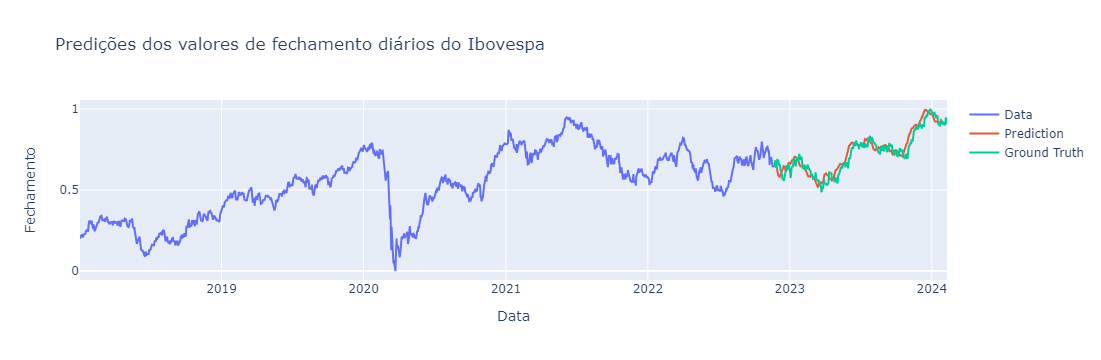

In [156]:
#  Plotando o gráfico com a série histórica real e as previsões do modelo

prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições dos valores de fechamento diários do Ibovespa",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

##### >>> LSTM Suavisado

Verificando a performance com suavização da série temporal:

In [157]:
df_s = ibovespa.copy()
df_s.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Volume', 'Var%', 'Flutuação'], inplace=True)
df_s = df_s.sort_values('Data')
df_s = df_s.reset_index()
df_s.head()

Data  Último
0 2018-01-02  77.891
1 2018-01-03  77.995
2 2018-01-04  78.647
3 2018-01-05  79.071
4 2018-01-08  79.379

Aplicando suavização exponencial:

* O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.

* Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

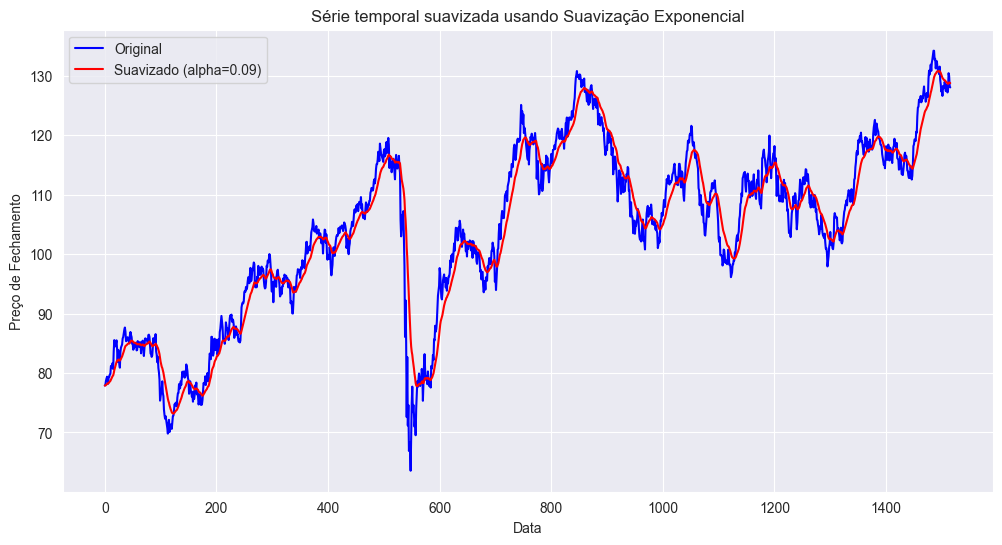

In [158]:
#  Suazivando a série temporal


alpha = 0.09
df_s['Smoothed_Close'] = df_s['Último'].ewm(alpha=alpha, adjust=False).mean()

#  Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df_s['Último'], label='Original', color='blue')
plt.plot(df.index, df_s['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série temporal suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [159]:
#  Teste de estacionariedade (ADF Test)

adf_result = adfuller(df_s['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.4903179531774042
p-value: 0.11784787916702782
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.4903179531774042
Valor-p: 0.11784787916702782
Valores Críticos:
   1%: -3.434696697851678
   5%: -2.8634597924260303
   10%: -2.567792072971565


In [160]:
df_s.drop(columns=['Último'], inplace=True)
df_s.head()

Data  Smoothed_Close
0 2018-01-02       77.891000
1 2018-01-03       77.900360
2 2018-01-04       77.967558
3 2018-01-05       78.066867
4 2018-01-08       78.184959

In [161]:
close_data_s = df_s['Smoothed_Close'].values
close_data_s = close_data_s.reshape(-1,1) #transformar em array

scaler_s = MinMaxScaler(feature_range=(0, 1))
scaler_s = scaler_s.fit(close_data_s)
close_data_s = scaler_s.transform(close_data_s)

In [162]:
split_percent_s = 0.80
split_s = int(split_percent_s*len(close_data_s))

close_train_s = close_data_s[:split_s]
close_test_s = close_data_s[split_s:]

date_train_s = df_s['Data'][:split_s]
date_test_s = df_s['Data'][split_s:]

print(len(close_train_s))
print(len(close_test_s))

1212
304


In [163]:
# Gerando sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back_s = 5

train_generator_s = TimeseriesGenerator(close_train_s, close_train_s, length=look_back_s, batch_size=20)
test_generator_s = TimeseriesGenerator(close_test_s, close_test_s, length=look_back_s, batch_size=1)

In [164]:
np.random.seed(7)

model_s = Sequential()
model_s.add(LSTM(100, activation='relu', input_shape=(look_back_s,1)))
model_s.add(Dense(1)),

optimizer_s = Adam(learning_rate=0.001)
model_s.compile(optimizer=optimizer_s, loss='mse', metrics=[MeanSquaredError()])

num_epochs_s = 100
model_s.fit(train_generator_s, epochs=num_epochs_s, verbose=1)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1823 - mean_squared_error: 0.1823
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2822e-04 - mean_squared_error: 3.2822e-04
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4341e-04 - mean_squared_error: 3.4341e-04
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8133e-04 - mean_squared_error: 4.8133e-04
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9963e-04 - mean_squared_error: 4.9963e-04
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5533e-04 - mean_squared_error: 3.5533e-04
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3119e-04 - mean_squared_error: 4.3119e-04
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5358e-04 - mean_squared_error: 6.53

In [165]:
#  Avaliando o modelo nos dados de teste

mse_s = model.evaluate(test_generator_s, verbose=1)
print("Erro Quadrático Médio:", mse_s[0])

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0411 - mean_squared_error: 0.0411
Erro Quadrático Médio: 0.059076182544231415


In [166]:
#  Fazendo previsões usando o conjunto de teste
test_predictions_s = model_s.predict(test_generator_s)

test_predictions_inv_s = scaler_s.inverse_transform(test_predictions_s.reshape(-1, 1))
test_actuals_inv_s = scaler_s.inverse_transform(np.array(close_test_s).reshape(-1, 1))

test_actuals_inv_s = test_actuals_inv_s[:len(test_predictions_inv_s)]

# Calculando o MAPE
mape_s = np.mean(np.abs((test_actuals_inv_s - test_predictions_inv_s) / test_actuals_inv_s)) * 100
print(f"MAPE: {mape_s:.2f}%")

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAPE: 0.87%


299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


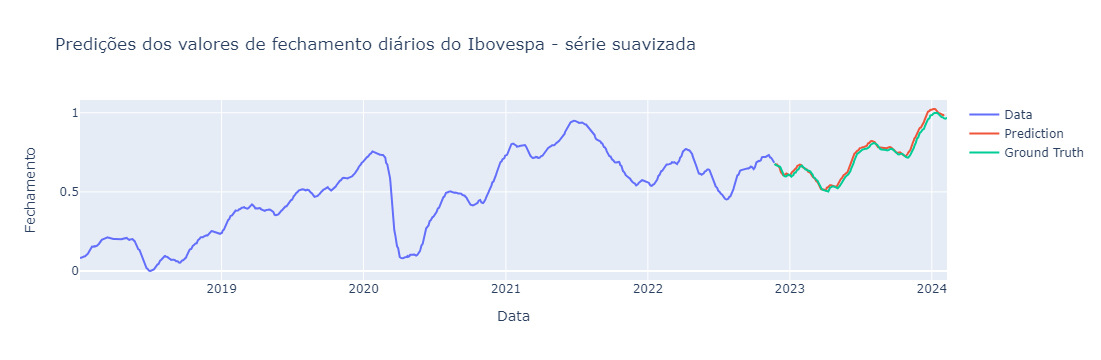

In [167]:
prediction_s = model_s.predict(test_generator_s)

close_train_s = close_train_s.reshape((-1))
close_test_s = close_test_s.reshape((-1))
prediction_s = prediction_s.reshape((-1))

trace1 = go.Scatter(
    x = date_train_s,
    y = close_train_s,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test_s,
    y = prediction_s,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test_s,
    y = close_test_s,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições dos valores de fechamento diários do Ibovespa - série suavizada",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

# Realizando o Forecasting com o modelo **LSTM SEM SUAVIZAÇÃO**

In [168]:
close_data = close_data.reshape((-1))


# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df['Data'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

In [169]:
num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


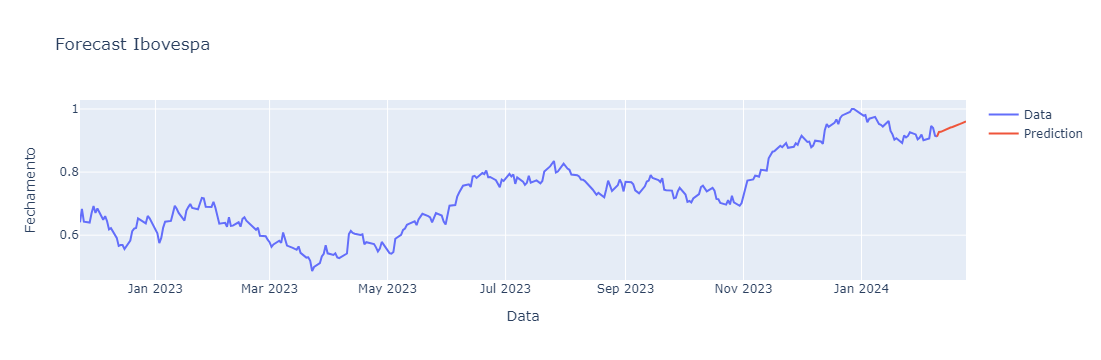

In [170]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast Ibovespa",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

Organizando os dados em um Dataframe

In [171]:
df = pd.DataFrame(df)
df_past = df[['Data','Último']]
df_past.rename(columns={'Último': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Data'] = pd.to_datetime(df_past['Data'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

Data  Actual  Forecast
0 2018-01-02  77.891       NaN
1 2018-01-03  77.995       NaN
2 2018-01-04  78.647       NaN

In [172]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast) # retransformando os dados para escala real

In [173]:
df_future = pd.DataFrame(columns=['Data', 'Actual', 'Forecast'])
df_future['Data'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

Data  Actual    Forecast
0 2024-02-09     NaN  128.026000
1 2024-02-10     NaN  129.037491
2 2024-02-11     NaN  129.081241
3 2024-02-12     NaN  129.295409
4 2024-02-13     NaN  129.509639

In [174]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Data')
results.head()

Actual  Forecast
Data                        
2018-01-02  77.891       NaN
2018-01-03  77.995       NaN
2018-01-04  78.647       NaN
2018-01-05  79.071       NaN
2018-01-08  79.379       NaN

In [175]:
results.tail()

Actual    Forecast
Data                          
2024-02-20     NaN  130.673769
2024-02-21     NaN  130.853566
2024-02-22     NaN  131.041429
2024-02-23     NaN  131.229590
2024-02-24     NaN  131.418412

In [176]:
results2023 =  results.loc['2023-01-01':]

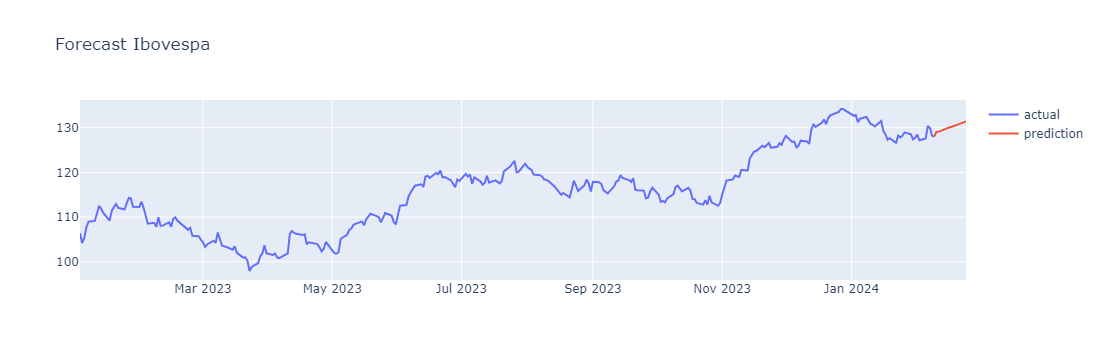

'temp-plot.html'

In [177]:
plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast Ibovespa'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

import plotly as ply
ply.offline.plot(fig)

# Conclusão


Visualizando o gráfico da série histórica (abaixo), percebemos uma grande valorização do índice Ibovespa, da ordem de 840%, se considerarmos os valores inicial e final da série. Porém, notamos também que o percurso teve várias quedas e retomadas, e trazemos alguns fatos que ajudam, em parte, a explicar esses movimentos.

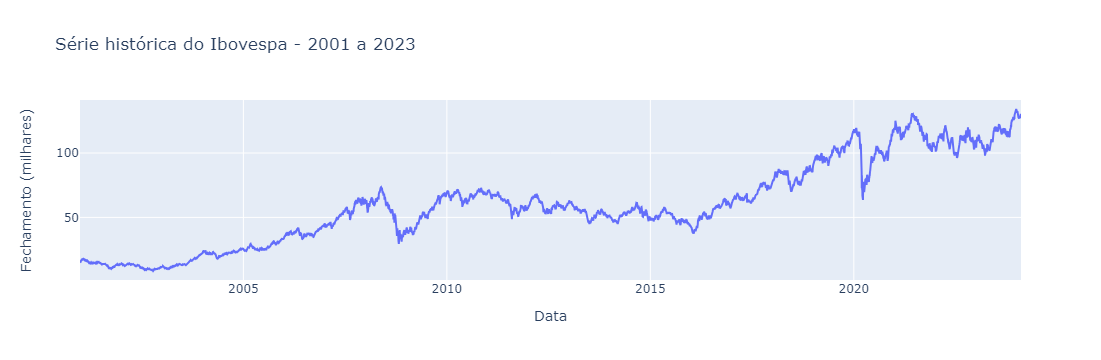

In [179]:
serie = pd.read_csv('Dados Históricos - Ibovespa.csv')
serie['Data'] = pd.to_datetime(serie['Data'], format='%d.%m.%Y')
trace1 = go.Scatter(x = serie['Data'], y = serie['Último'], mode = 'lines', name = 'Data')
layout = go.Layout(title = "Série histórica do Ibovespa - 2001 a 2023", xaxis = {'title' : "Data"}, yaxis = {'title' : "Fechamento (milhares)"})
fig = go.Figure(data=[trace1], layout=layout)
fig.show()

Fatos:

1. Crise Financeira Global de 2008: A crise financeira global teve um impacto significativo nos mercados financeiros em todo o mundo, incluindo o mercado de ações brasileiro. A queda do dólar americano, como parte desse cenário de crise, pode ter sido acompanhada por uma aversão ao risco por parte dos investidores estrangeiros, levando a uma fuga de capitais dos mercados emergentes, incluindo o Brasil. Isso pode ter contribuído para uma queda na Ibovespa devido à venda de ações por investidores estrangeiros, bem como à incerteza econômica global. Desse modo, as expectativas de crescimento econômico foram reduzidas e em consequência houve redução nas previsões para o PIB do país.

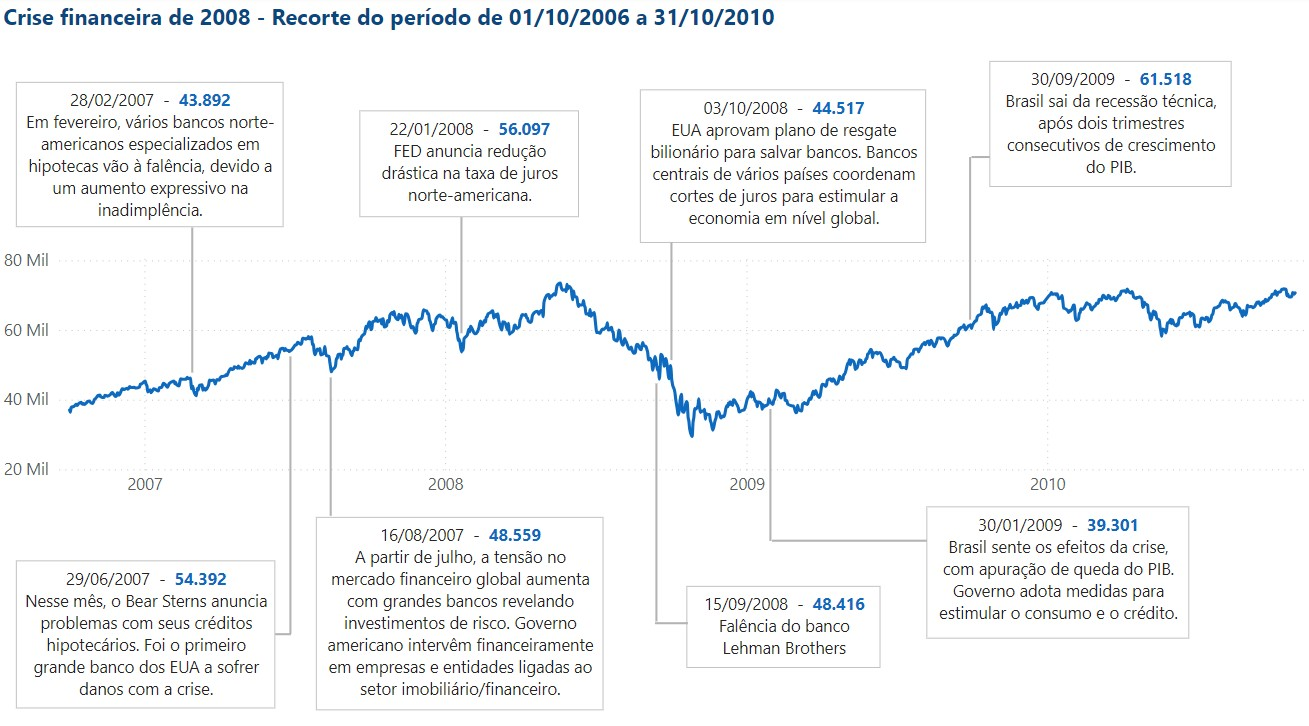

2. Eleições Presidenciais nos EUA em 2016: As eleições presidenciais nos Estados Unidos em 2016 também geraram incerteza nos mercados financeiros globais. A incerteza política em uma das maiores economias do mundo pode ter impactado negativamente o sentimento dos investidores em relação aos mercados emergentes, incluindo o Brasil. A volatilidade nos mercados financeiros globais pode ter influenciado a Ibovespa, levando a flutuações nos preços das ações

3. Pandemia de COVID-19 em 2020: A pandemia de COVID-19 teve um impacto devastador nos mercados financeiros em todo o mundo, incluindo a Bolsa de Valores brasileira. A queda do dólar americano em 2020 foi acompanhada por uma série de medidas de restrição e lockdown em todo o mundo, resultando em uma desaceleração econômica global e em recessões em muitos países. Isso afetou negativamente as empresas brasileiras listadas na Ibovespa, especialmente aquelas dependentes do comércio internacional e do turismo

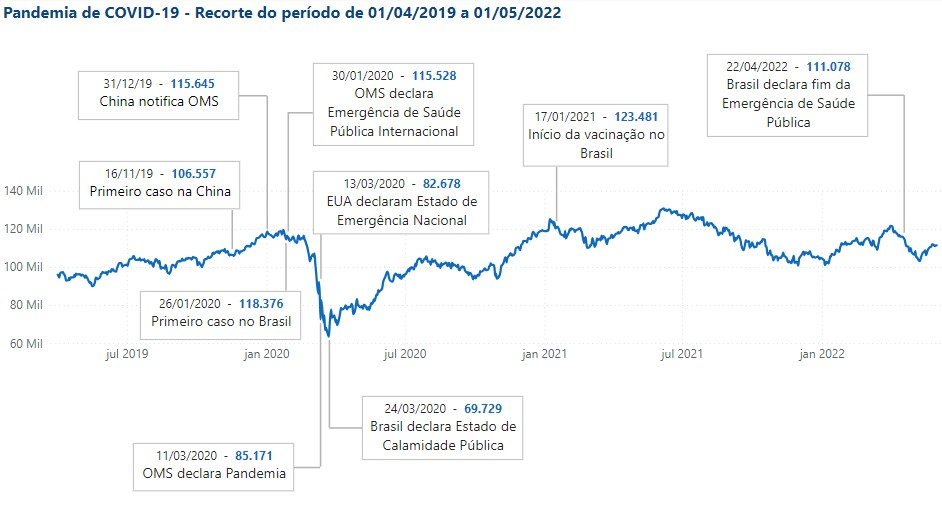

4. Cenário de 2023: No Brasil, as atenções se voltaram para as discussões em torno do cenário fiscal do país e quais ações o novo governo poderia implementar para conter os gastos públicos. No cenário internacional, o foco está na expectativa de um ciclo de redução das taxas de juros nas economias desenvolvidas, enquanto a persistência da inflação elevada e sinais tardios de desaceleração econômica continuaram exercendo pressão sobre as taxas de juros nos Estados Unidos e na Europa.











Resultados dos Modelos de Análise de Série Temporal:

ARIMA MAPE: 484.07%

PROPHET MAPE: 4.27%

LSTM MAPE: 2.06%

LSTM Suavizado MAPE: 0.87%


Ao comparar os dados de diferentes modelos para uma base não estacionária, é crucial considerar modelos que levem em conta essa característica. Alguns modelos inadequados incluem:

**Modelos Lineares Simples:** Podem não capturar padrões não lineares ou tendências temporais nos dados.

**Médias Móveis de Ordem Baixa:** Podem não capturar variações complexas ou padrões de longo prazo.

**ARIMA:** Embora úteis para séries estacionárias, podem não ser adequados para séries não estacionárias, a menos que combinados com técnicas de diferenciação.
Este modelo tem por objetivo descrever a autocorrelação dos dados, sendo um algoritmo composto por autoregressão, médias móveis e diferenciação. Com base neste modelo, calculamos o MAPE (Mean Absolute Percentage Error) igual a 484,11%, onde concluímos que as previsões do modelo estão muito distantes dos valores reais.

**Modelos Exponenciais Suavizados:** Podem não ser robustos o suficiente para tendências ou padrões complexos.

**Modelos de Séries Temporais Lineares:** Podem não capturar variações adequadas em séries não estacionárias.

<br>Alguns modelos apropriados para séries não estacionárias são:

**Prophet:** Desenvolvido pelo Facebook, projetado para séries com sazonalidade, tendência e feriados irregulares. Fácil de usar e eficaz para dados ruidosos.
Este modelo tem por objetivo trabalhar com séries temporais que apresentam padrões sazonais fortes, pontos de mudanças e seja capaz de prever tendências. Com base neste modelo, calculamos o MAPE e apresentou resultado igual a 4,27%, onde concluímos o resultado deste modelo está bom, pois com MAPE = 4,27%, temos que a acurácia deste modelo é de 95,72%.

**LSTM (Long Short-Term Memory):** Rede neural recorrente projetada para capturar dependências de longo prazo em séries temporais. Adequado para padrões não lineares e mudanças abruptas nos dados.
Este modelo tem por objetivo trabalhar com redes neurais recorrentes e processaos dados individualmente, ou seja, uma observação da série temporal de cada vez.
 - Com base neste modelo, calculamos o MAPE (Mean Absolute Percentage Error) igual a 2,06%, onde concluímos que a acurácia é de 97,85%.
 - Analisando o teste de Dickey-Fuller Aumentado (ADF), concluímos que o Teste Estatístico foi de -2.4903 e que é menor que todos os valores críticos apontados no resultado deste teste de estacionariedade, ou seja, não podemos rejeitar a hipótese nula de que a série é não estacionária.
 - Ao analisar o p-value = 0.11784, temos que ele é maior que o nível de significância de 0.05, logo reforça a conclusão de que não podemos recusar a hipótese nula de não estacionariedade.

**LSTM Suavizado:** É o modelo do LSTM, no entanto ajustado de acordo com as necessidade de quem esta executando a série. Neste, aplica-se filtros e/ou parâmetros afim de suavizar o resultado do modelo. Para o teste que realizamos, o resultado foi de 0,87%, nos trazendo acurácia de 99,31%.

Em resumo, tanto o Prophet quanto o LSTM são ferramentas poderosas para modelagem e previsão de séries não estacionárias. O Prophet é mais adequado para casos onde a facilidade de uso e a capacidade de lidar com sazonalidade são importantes, enquanto o LSTM é mais útil para padrões complexos e não lineares. A escolha depende das características específicas dos dados e dos objetivos da análise.

### Analisando o MAPE obtidos de cada modelo para séries não estacionárias:

In [180]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao [previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])
print(f"MAPE Prophet: {mape:.2f}%")






#  Fazendo previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]


#  Calculando o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100
print(f'MAPE LSTM: {mape:.4f}%')


MAPE Prophet: 4.27%
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAPE LSTM: 2.0602%


Com base na análise dos dados dos modelos previamente executados e considerando as métricas de erro percentual absoluto médio (MAPE) e a precisão geral do modelo, pode-se concluir que o modelo LSTM demonstrou ser mais eficiente em comparação com o outro modelo avaliado.
Isso é evidenciado pelos valores inferiores de MAPE obtidos pelo modelo LSTM, indicando uma melhor capacidade de previsão e uma menor discrepância entre as previsões e os valores reais.
Além disso, ao considerar a acurácia geral do modelo, o LSTM também mostrou um desempenho mais consistente e confiável.

Além disso, é importante destacar o perigo associado à suavização excessiva dos dados. Embora a suavização possa ser útil para remover ruídos e padrões de curto prazo nos dados, existe o risco de ocorrer overfitting, onde o modelo se ajusta demasiadamente aos dados de treinamento, mascarando nuances importantes e prejudicando a capacidade de generalização para novos dados. Portanto, ao realizar a suavização dos dados, é crucial encontrar um equilíbrio entre a redução do ruído e a preservação das características essenciais do conjunto de dados, garantindo assim que o modelo capture adequadamente os padrões subjacentes e produza previsões precisas e confiáveis.


Portanto, com base nessas análises, o modelo LSTM é a escolha preferencial para este conjunto de dados e tarefa de previsão.



# Referências Bibliográficas



1. https://g1.globo.com/economia/noticia/2020/12/12/como-a-pandemia-baguncou-a-economia-brasileira-em-2020.ghtml

2. https://varos.com.br/blog/artigo/a-crise-de-2008

3. https://www.politize.com.br/crise-financeira-de-2008/

4. https://g1.globo.com/economia/noticia/2020/12/18/bolsas-dos-eua-fecham-em-queda-em-meio-ao-impasse-do-pacote-de-estimulos.ghtml

5. https://www.bbc.com/portuguese/internacional-55980145

6. https://g1.globo.com/economia/especial-publicitario/inteligencia-financeira/noticia/2022/10/20/-que-acontece-com-seus-investimentos-quando-a-taxa-selic-cai.ghtml

7. https://www.monolitonimbus.com.br/machine-learning-de-series-temporais-LSTM/

8. https://www.monolitonimbus.com.br/prophet/


